# 03 EDA ON PRICE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # optional, nice for advanced EDA

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor  # example regressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose


import sys

from pathlib import Path 




In [3]:
# Project root & data paths
project_root = Path().resolve().parent
df_pre_path = project_root / "data" / "interim" / "data_preprocessed.parquet"
df_pre = pd.read_parquet(df_pre_path)

src_path = project_root / "src"
sys.path.append(str(src_path))


In [4]:

listings_extended_path = project_root / "data" / "raw" / "listings_extended.csv"

# Load the data
df_raw_listings_extended = pd.read_csv(listings_extended_path)
df_raw = df_raw_listings_extended.copy()  # Work on a copy to keep the original data intact

In [4]:
df_raw['host_since'] = pd.to_datetime(df_raw['host_since'], errors='coerce')
df_raw['first_review'] = pd.to_datetime(df_raw['first_review'], errors='coerce')

In [5]:
df_raw['last_scraped']

0        2024-09-17
1        2024-09-17
2        2024-09-17
3        2024-09-17
4        2024-09-18
            ...    
23700    2024-09-17
23701    2024-09-17
23702    2024-09-17
23703    2024-09-17
23704    2024-09-17
Name: last_scraped, Length: 23705, dtype: object

In [6]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df_raw.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df_raw.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 13 August 2008, and the most recent joined on 15 September 2024.


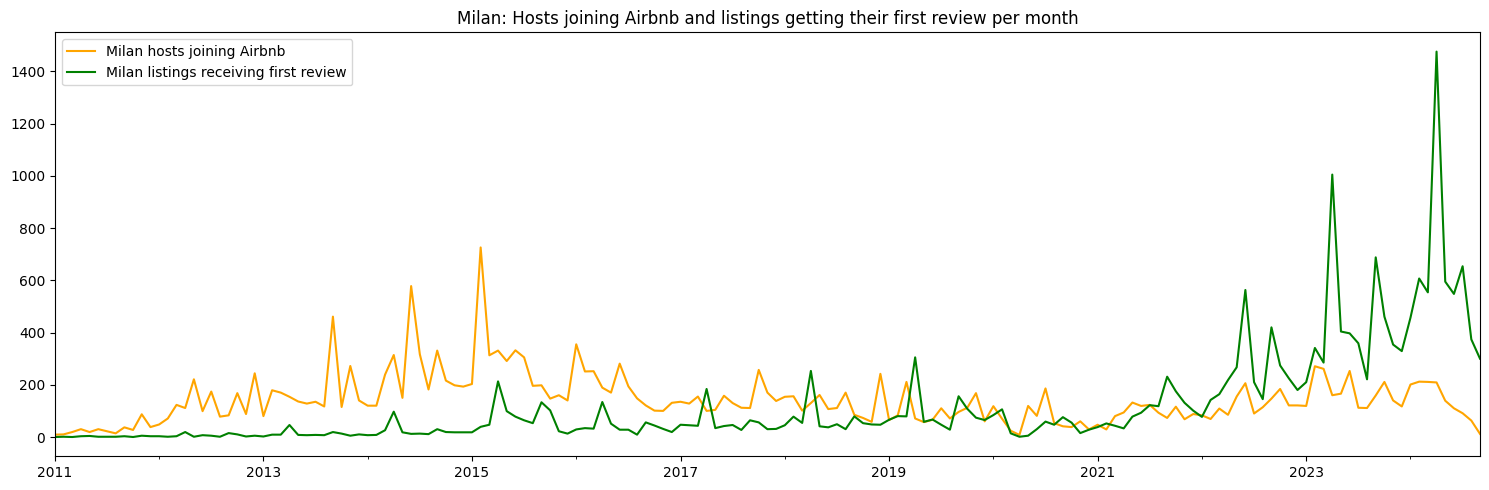

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

df_raw.set_index('host_since').resample('MS').size().plot(
    label='Milan hosts joining Airbnb', color='orange'
)
df_raw.set_index('first_review').resample('MS').size().plot(
    label='Milan listings receiving first review', color='green'
)

plt.title('Milan: Hosts joining Airbnb and listings getting their first review per month')
plt.legend()
plt.xlim('2011-01-01', '2024-09-17')  # Updated range from 2010 to 2025
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

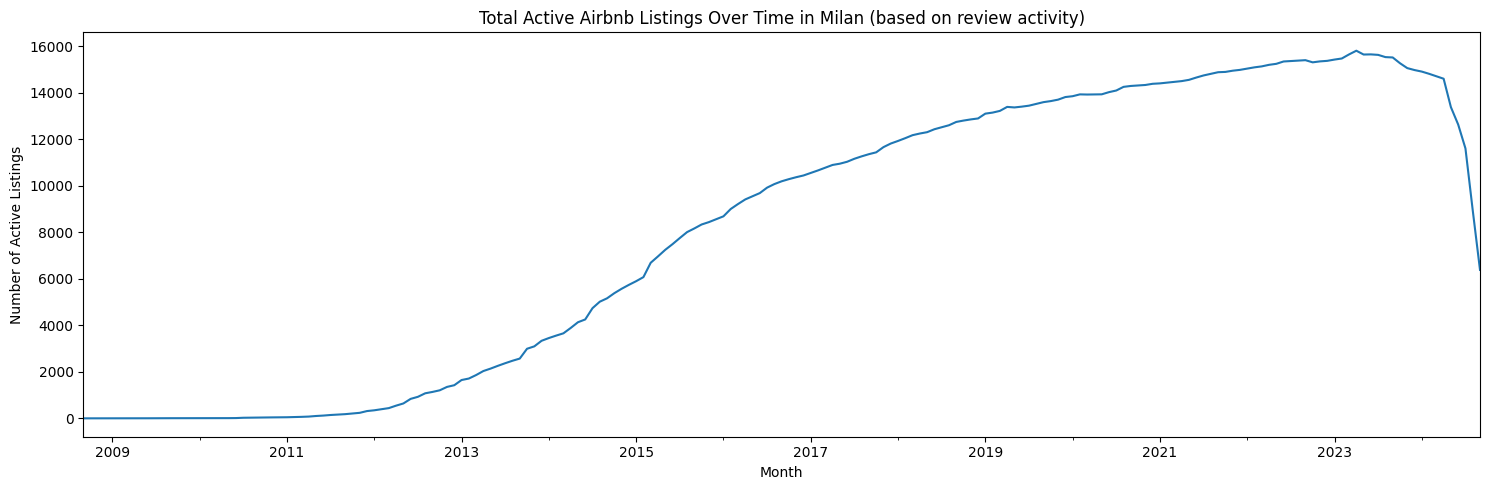

In [8]:
# Convert review dates
df_raw['first_review'] = pd.to_datetime(df_raw['first_review'], errors='coerce')
df_raw['last_review'] = pd.to_datetime(df_raw['last_review'], errors='coerce')

# Create a copy with only listings that have a last_review date
df_active = df_raw[['id', 'host_since', 'last_review']].dropna(subset=['last_review']).copy()

# For each listing, we assume it's "active" from host_since to last_review
# We’ll resample monthly and count how many listings were active

# Step 1: For each row, generate the months during which the listing was active
from pandas.tseries.offsets import MonthBegin

df_active['host_since'] = pd.to_datetime(df_active['host_since'])
df_active['last_review'] = pd.to_datetime(df_active['last_review'])

active_periods = []

for _, row in df_active.iterrows():
    active_months = pd.date_range(row['host_since'], row['last_review'], freq='MS')
    active_periods.extend(active_months)

# Step 2: Count how many listings were active each month
import pandas as pd
active_month_series = pd.Series(active_periods)
active_counts = active_month_series.value_counts().sort_index()

# Step 3: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
active_counts.plot()
plt.title("Total Active Airbnb Listings Over Time in Milan (based on review activity)")
plt.ylabel("Number of Active Listings")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

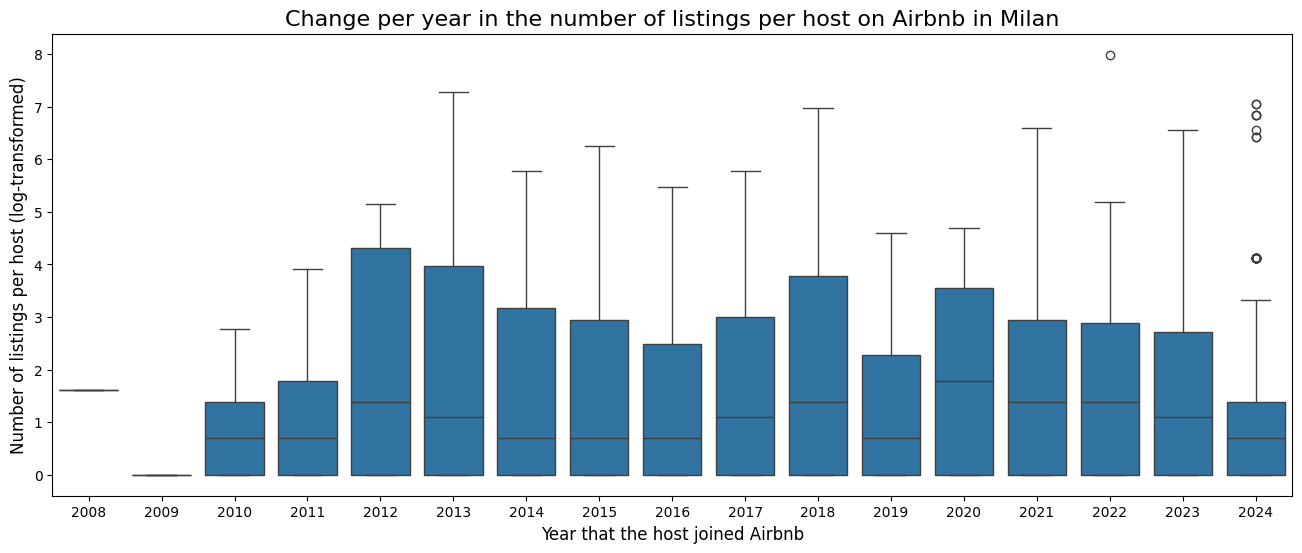

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(x=df.host_since.dt.year, y=np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Milan', fontsize=16)
plt.show()

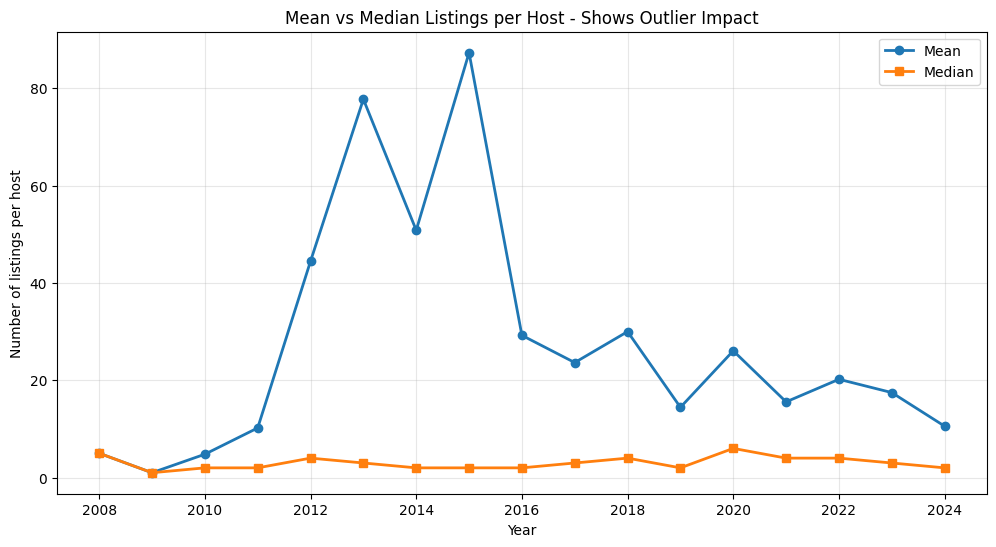

In [17]:
yearly_stats = df.groupby(df.host_since.dt.year)['host_listings_count'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_stats['host_since'], yearly_stats['mean'], marker='o', label='Mean', linewidth=2)
plt.plot(yearly_stats['host_since'], yearly_stats['median'], marker='s', label='Median', linewidth=2)
plt.title('Mean vs Median Listings per Host - Shows Outlier Impact')
plt.xlabel('Year')
plt.ylabel('Number of listings per host')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

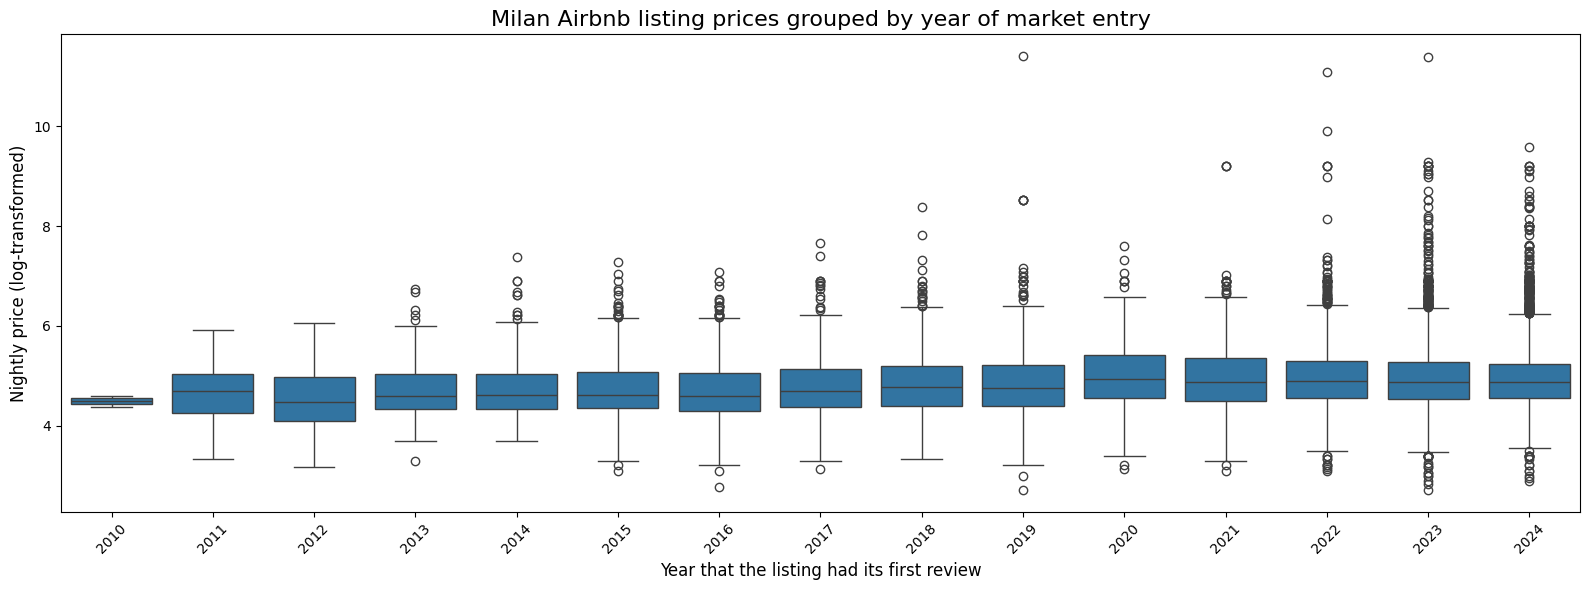

In [ ]:


# Create the figure
plt.figure(figsize=(16, 6))

# Convert price to numeric (remove $ signs, commas, etc.) and handle missing values
df['price_numeric'] = pd.to_numeric(df['price'].astype(str).str.replace('[$,]', '', regex=True), errors='coerce')

# Create boxplot with proper syntax - filter out NaN values
valid_data = df.dropna(subset=['price_numeric', 'first_review'])
sns.boxplot(data=valid_data, x=valid_data.first_review.dt.year, y=np.log(valid_data.price_numeric))

# Add labels and title
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title("Milan Airbnb listing prices grouped by year of market entry", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

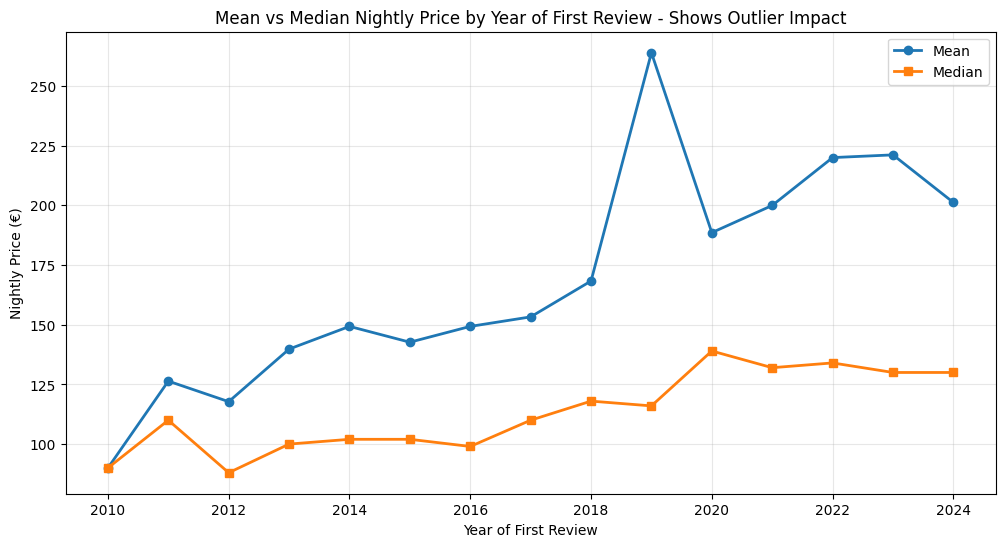

In [ ]:
# Group by first review year and calculate mean/median price
yearly_price_stats = df.groupby(df.first_review.dt.year)['price_numeric'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_price_stats['first_review'], yearly_price_stats['mean'], marker='o', label='Mean', linewidth=2)
plt.plot(yearly_price_stats['first_review'], yearly_price_stats['median'], marker='s', label='Median', linewidth=2)
plt.title('Mean vs Median Nightly Price by Year of First Review - Shows Outlier Impact')
plt.xlabel('Year of First Review')
plt.ylabel('Nightly Price (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## What is the overall distribution of prices?


In [ ]:
print(f"Nightly advertised prices range from €{min(df_pre.price)} to €{max(df_pre.price)}.")

Nightly advertised prices range from €14.0 to €90000.0.


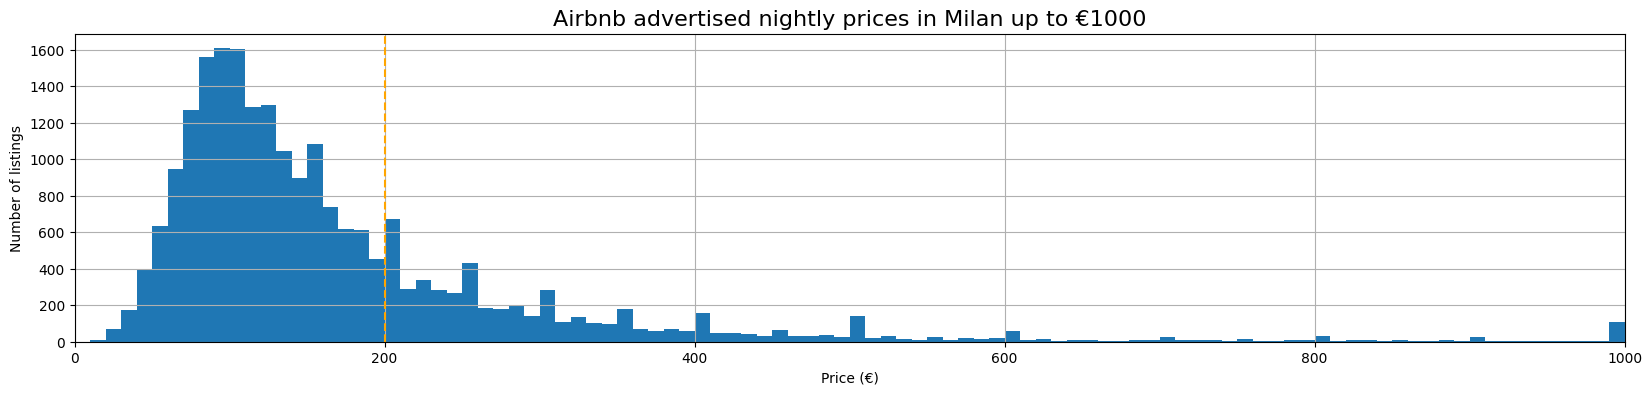

In [ ]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df_pre.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Milan up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

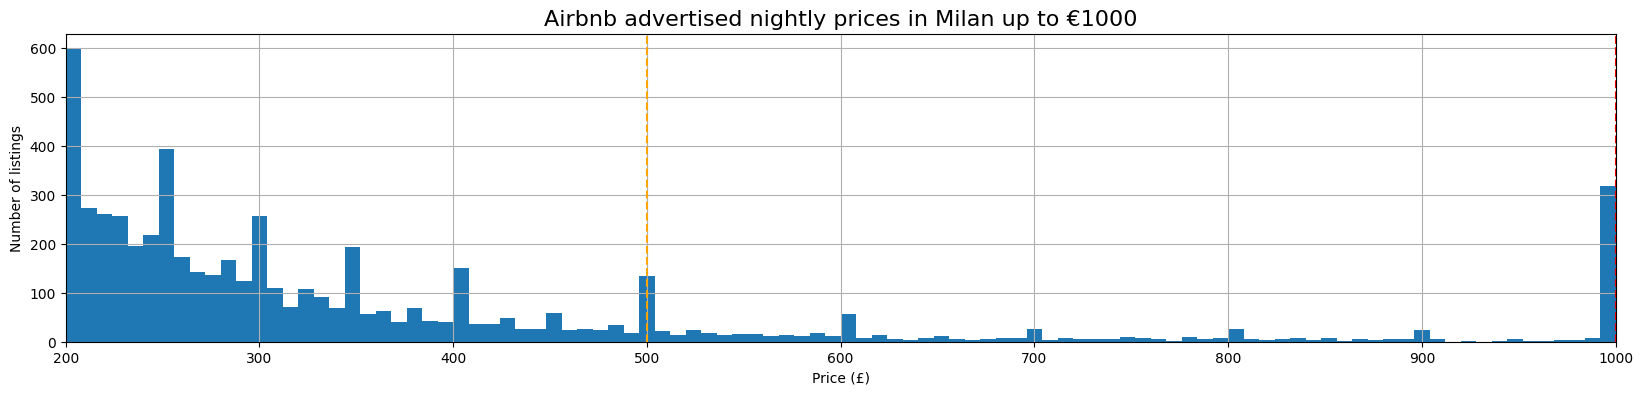

In [ ]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df_pre.price.hist(bins=100, range=(200, max(df_pre.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Milan up to €1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [3]:
# Project root & data paths
project_root = Path().resolve().parent
df_path = project_root / "data" / "interim" / "data_preprocessed.parquet"

# Load the data
df = pd.read_parquet(df_path)
df = df.copy()

# Check the structure and first rows
df.info()
df.head()

# Let's look at the shape of the dataset
print("Dataset shape (rows, columns):", df.shape)

# Column names
print("Column names:\n", df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
Index: 21961 entries, 0 to 23704
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            21961 non-null  int64         
 1   last_scraped                                  21961 non-null  datetime64[ns]
 2   host_location                                 21961 non-null  object        
 3   host_is_superhost                             21961 non-null  bool          
 4   host_listings_count                           21961 non-null  int64         
 5   host_total_listings_count                     21961 non-null  int64         
 6   host_identity_verified                        21961 non-null  bool          
 7   neighbourhood_cleansed                        21961 non-null  object        
 8   property_type                                 21961 non-null  object   

### Boolean Features Value Counts ###

--- host_is_superhost ---
host_is_superhost
False    11942
True      4997
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


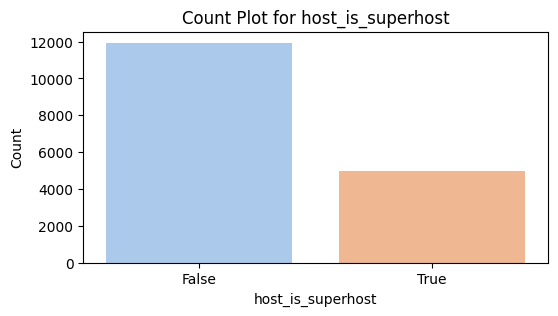


--- host_identity_verified ---
host_identity_verified
True     15951
False      988
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


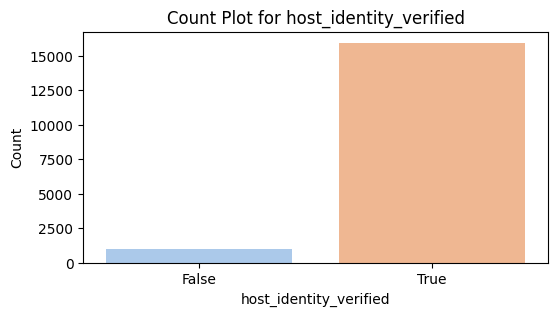


--- host_about_present ---
host_about_present
True     8923
False    8016
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


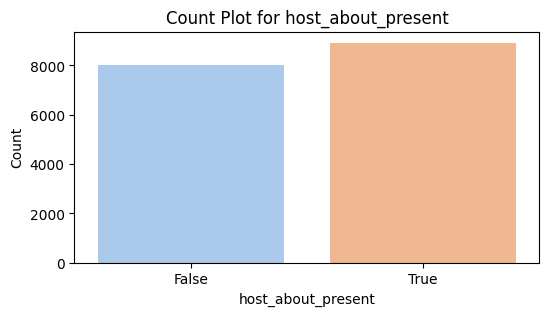


--- neighborhood_overview_present ---
neighborhood_overview_present
True     8916
False    8023
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


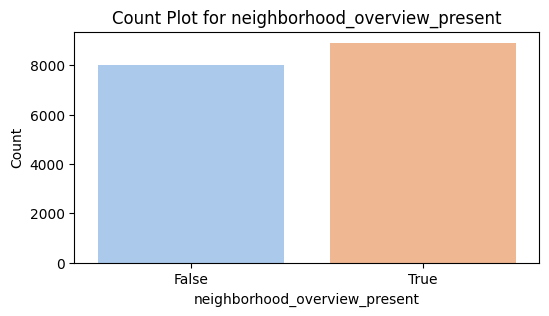


--- host_location_missing ---
host_location_missing
False    13846
True      3093
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


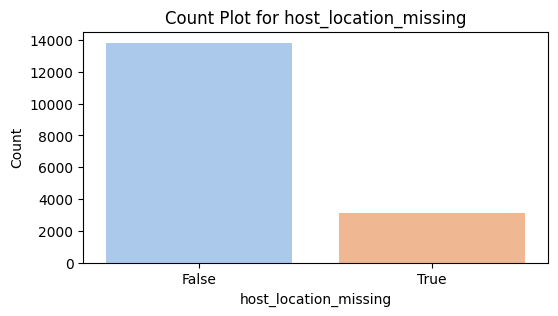


--- number_of_reviews_0_vs_altro ---
number_of_reviews_0_vs_altro
False    14155
True      2784
Name: count, dtype: int64


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/3560744012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train[col], palette="pastel")


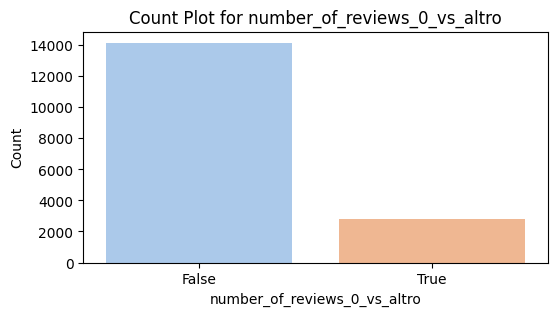

In [9]:
#########################################
# 3. Data Exploration: Boolean Features
#########################################
if bool_cols:
    print("### Boolean Features Value Counts ###")
    for col in bool_cols:
        print(f"\n--- {col} ---")
        print(X_train[col].value_counts(dropna=False))
        plt.figure(figsize=(6, 3))
        sns.countplot(x=X_train[col], palette="pastel")
        plt.title(f"Count Plot for {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()
else:
    print("No boolean columns found in the training set.")

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Il dizionario che associa ogni quartiere al rispettivo municipio
neighborhood_to_zone = {
    # ZONA 1 (Municipio 1)
    "DUOMO": 1,
    "SARPI": 1,
    "TICINESE": 1,
    "PORTA ROMANA": 1,
    "BRERA": 1,
    "MAGENTA - S. VITTORE": 1,
    "GUASTALLA": 1,
    "PARCO SEMPIONE": 1,
    "PAGANO": 1,
    "GIARDINI PORTA VENEZIA": 1,
    # ZONA 2 (Municipio 2)
    "CENTRALE": 2,
    "VIALE MONZA": 2,
    "LORETO": 2,
    "PADOVA": 2,
    "GRECO": 2,
    "ADRIANO": 2,
    # ZONA 3 (Municipio 3)
    "CITTA' STUDI": 3,
    "BUENOS AIRES - VENEZIA": 3,
    "LAMBRATE": 3,
    "PARCO LAMBRO - CIMIANO": 3,
    # ZONA 4 (Municipio 4)
    "XXII MARZO": 4,
    "UMBRIA - MOLISE": 4,
    "LODI - CORVETTO": 4,
    "CORSICA": 4,
    "ORTOMERCATO": 4,
    "ROGOREDO": 4,
    "PARCO MONLUE' - PONTE LAMBRO": 4,
    "MECENATE": 4,
    "PARCO FORLANINI - ORTICA": 4,
    "TRIULZO SUPERIORE": 4,
    # ZONA 5 (Municipio 5)
    "TIBALDI": 5,
    "STADERA": 5,
    "VIGENTINA": 5,
    "GRATOSOGLIO - TICINELLO": 5,
    "RIPAMONTI": 5,
    "EX OM - MORIVIONE": 5,
    "SCALO ROMANA": 5,
    "CHIARAVALLE": 5,
    "PARCO DELLE ABBAZIE": 5,
    "PARCO AGRICOLO SUD": 5,
    "QUINTOSOLE": 5,
    "RONCHETTO DELLE RANE": 5,
    # ZONA 6 (Municipio 6)
    "LORENTEGGIO": 6, 
    "NAVIGLI": 6,
    "GIAMBELLINO": 6,
    "S. CRISTOFORO": 6,
    "TORTONA": 6,
    "BARONA": 6,
    "LAMENTE": 6,
    "RONCHETTO SUL NAVIGLIO": 6,
    "PARCO DEI NAVIGLI": 6,
    # ZONA 7 (Municipio 7)
    "WASHINGTON": 7,
    "BANDE NERE": 7,
    "DE ANGELI - MONTE ROSA": 7,
    "BAGGIO": 7,
    "QUARTO CAGNINO": 7,
    "S. SIRO": 7,
    "FORZE ARMATE": 7,
    "TRENNO": 7,
    "FIGINO": 7,
    "CANTALUPA": 7,
    "MUGGIANO": 7,
    "QUINTO ROMANO": 7,
    "SELINUNTE": 7,
    "PARCO BOSCO IN CITTÀ": 7,
    # ZONA 8 (Municipio 8)
    "VILLAPIZZONE": 8,
    "GALLARATESE": 8,
    "PORTELLO": 8,
    "QT 8": 8,
    "TRE TORRI": 8,
    "QUARTO OGGIARO": 8,
    "MAGGIORE - MUSOCCO": 8,
    "SACCO": 8,
    "STEPHENSON": 8,
    "CASCINA TRIULZA - EXPO": 8,
    # ZONA 9 (Municipio 9)
    "ISOLA": 9,
    "NIGUARDA - CA' GRANDA": 9,
    "BOVISASCA": 9,
    "GARIBALDI REPUBBLICA": 9,
    "GHISOLFA": 9,
    "BOVISA": 9,
    "MACIACHINI - MAGGIOLINA": 9,
    "DERGANO": 9,
    "FARINI": 9,
    "BICOCCA": 9,
    "PARCO NORD": 9,
    "COMASINA": 9,
    "BRUZZANO": 9,
    "AFFORI": 9
}


In [11]:

# 1. Combina le colonne "quartiere", "room_type" e "price" (target) in un DataFrame
df_price = pd.concat([X_train["quartiere"], X_train["room_type"], y_train], axis=1)
df_price.columns = ["quartiere", "room_type", "price"]

# Assicurati che i nomi dei quartieri siano in maiuscolo per il mapping (oppure normalizza il dizionario)
df_price["quartiere"] = df_price["quartiere"].str.upper()

# Aggiungi la colonna "municipio" utilizzando il dizionario
df_price["municipio"] = df_price["quartiere"].map(neighborhood_to_zone)

# 2. Carica il file GeoJSON dei quartieri (confinamenti)
neighborhoods_geo_path = project_root / "data" / "raw" / "neighbourhoods.geojson"
gdf = gpd.read_file(neighborhoods_geo_path)

# Rinomina la colonna "neighbourhood" in "quartiere" e normalizza in maiuscolo
gdf = gdf.rename(columns={'neighbourhood': 'quartiere'})
gdf["quartiere"] = gdf["quartiere"].str.upper()

# Aggiungi la colonna "municipio" al GeoDataFrame utilizzando il dizionario
gdf["municipio"] = gdf["quartiere"].map(neighborhood_to_zone)

# Raggruppa (dissolve) i poligoni dei quartieri per "municipio"
gdf_municipio = gdf.dissolve(by="municipio", as_index=False)

# 3. Ottieni le tipologie di stanza uniche
room_types = df_price["room_type"].unique()


In [12]:
df_price.columns

Index(['quartiere', 'room_type', 'price', 'municipio'], dtype='object')

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/1200611141.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


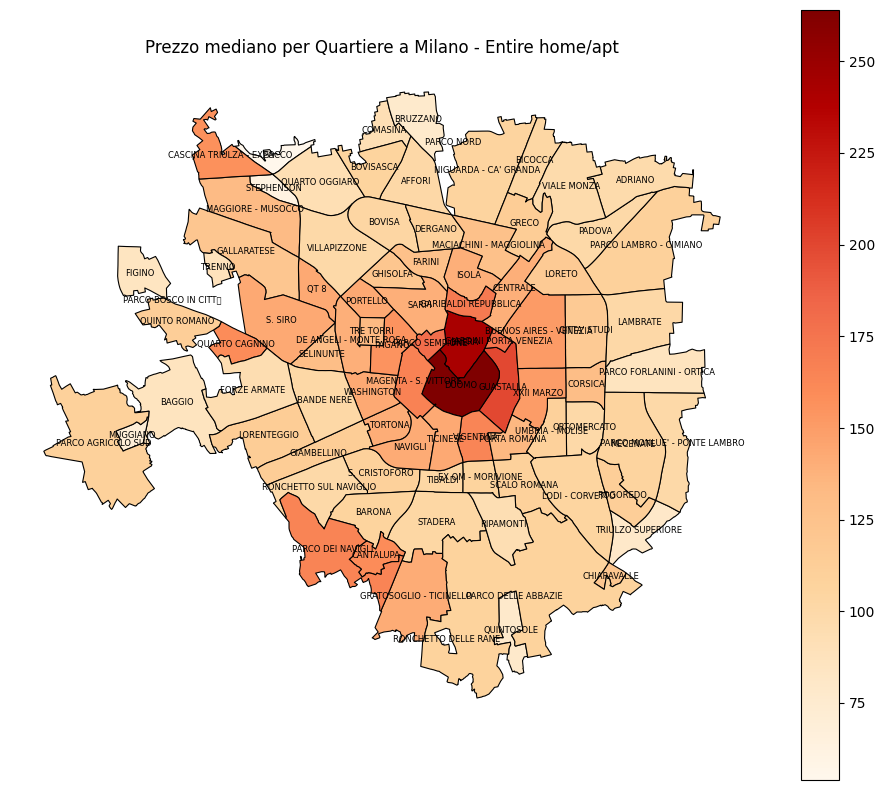

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/1200611141.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


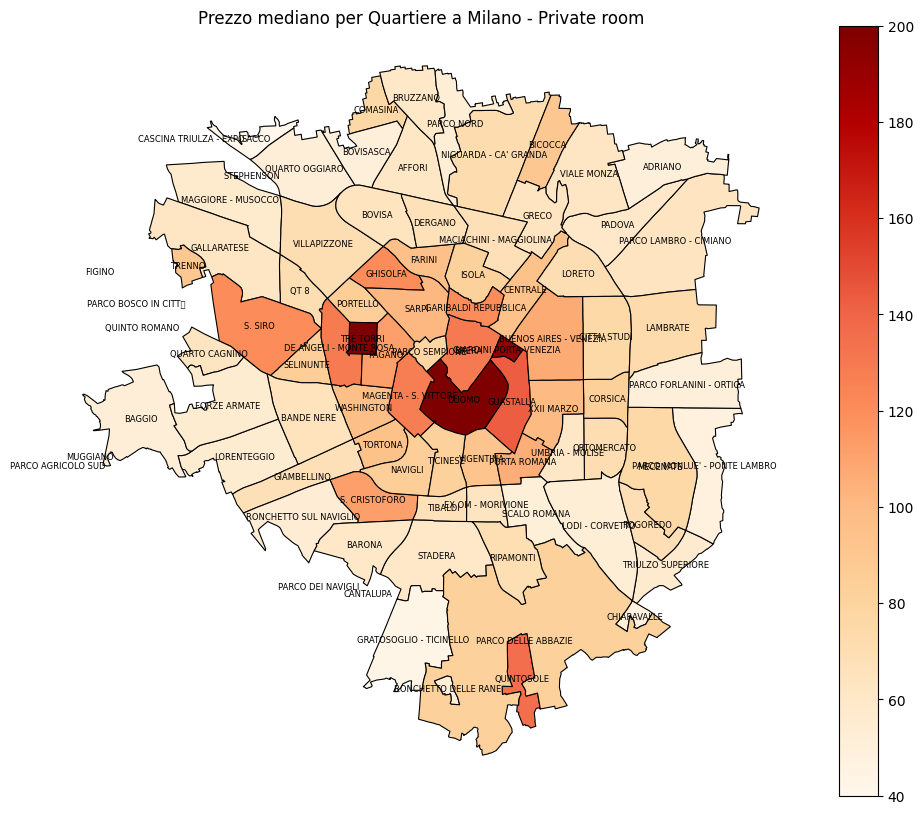

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/1200611141.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


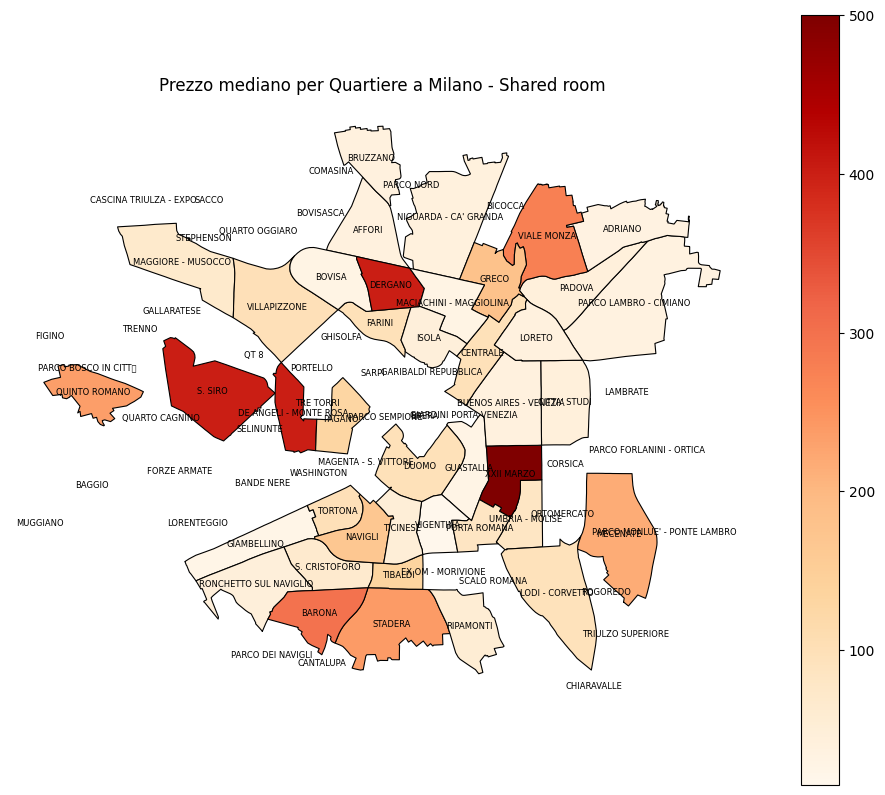

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/1200611141.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid


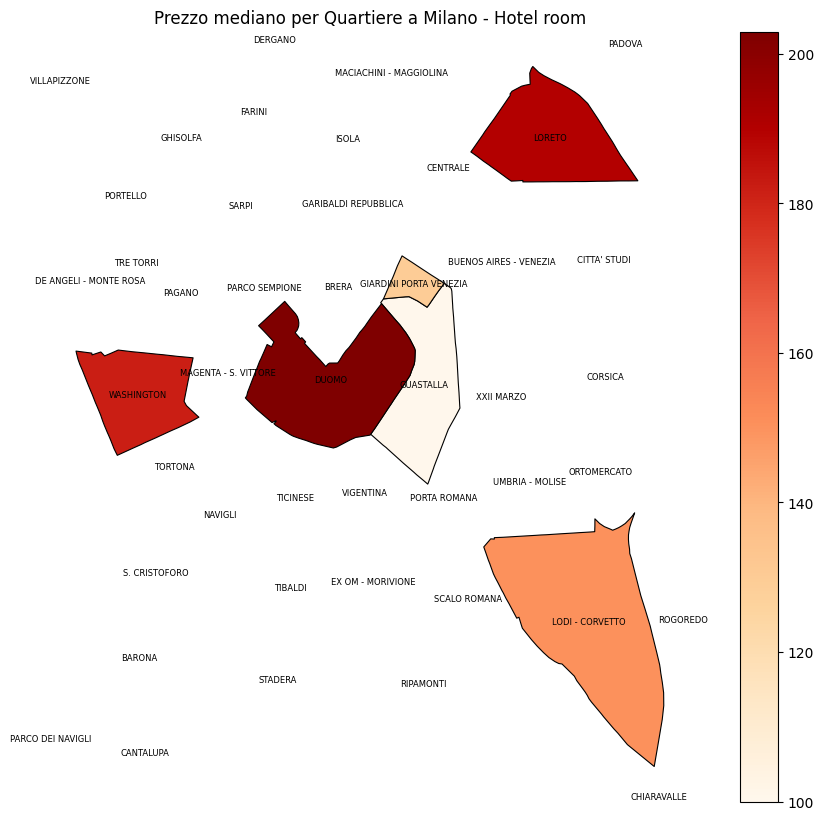

In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Combine quartiere, room_type, and price into a single DataFrame
df_price = pd.concat([X_train["quartiere"], X_train["room_type"], y_train], axis=1)
df_price.columns = ["quartiere", "room_type", "price"]

# 2. Load the GeoJSON neighborhood data
neighborhoods_geo_path = project_root / "data" / "raw" / "neighbourhoods.geojson"
gdf = gpd.read_file(neighborhoods_geo_path)

# 3. Rename column to match "quartiere" if necessary
gdf = gdf.rename(columns={'neighbourhood': 'quartiere'})

# 4. Get the unique room types
room_types = df_price["room_type"].unique()

for rt in room_types:
    # Filtra i dati per questo room_type
    subset = df_price[df_price["room_type"] == rt]
    # Calcola il prezzo medio per quartiere
    avg_price = subset.groupby("quartiere")["price"].median().reset_index()
    avg_price.columns = ["quartiere", "avg_price"]
    
    # Merge con il GeoDataFrame
    gdf_merged = gdf.merge(avg_price, on="quartiere", how="left")
    
    # Calcola il centroid di ogni quartiere
    # (Attenzione: alcuni centroidi potrebbero cadere fuori dal poligono, specie se ha forma irregolare)
    gdf_merged["centroid"] = gdf_merged.geometry.centroid
    
    # Crea la figura
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Disegna la mappa colorata in base a "avg_price"
    gdf_merged.plot(
        column="avg_price",
        cmap="OrRd",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )
    
    # Aggiungi il nome del quartiere sopra il disegno
    for idx, row in gdf_merged.iterrows():
        # Verifica che la geometria e il nome quartiere siano validi
        if not row["geometry"].is_empty and pd.notnull(row["quartiere"]):
            ax.annotate(
                text=row["quartiere"],
                xy=(row["centroid"].x, row["centroid"].y),
                ha="center",            # center horizontally
                va="center",            # center vertically
                fontsize=6,             # regola la dimensione del font
                color="black"
            )
    
    ax.set_title(f"Prezzo mediano per Quartiere a Milano - {rt}")
    ax.axis("off")
    plt.show()


/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/4019620641.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


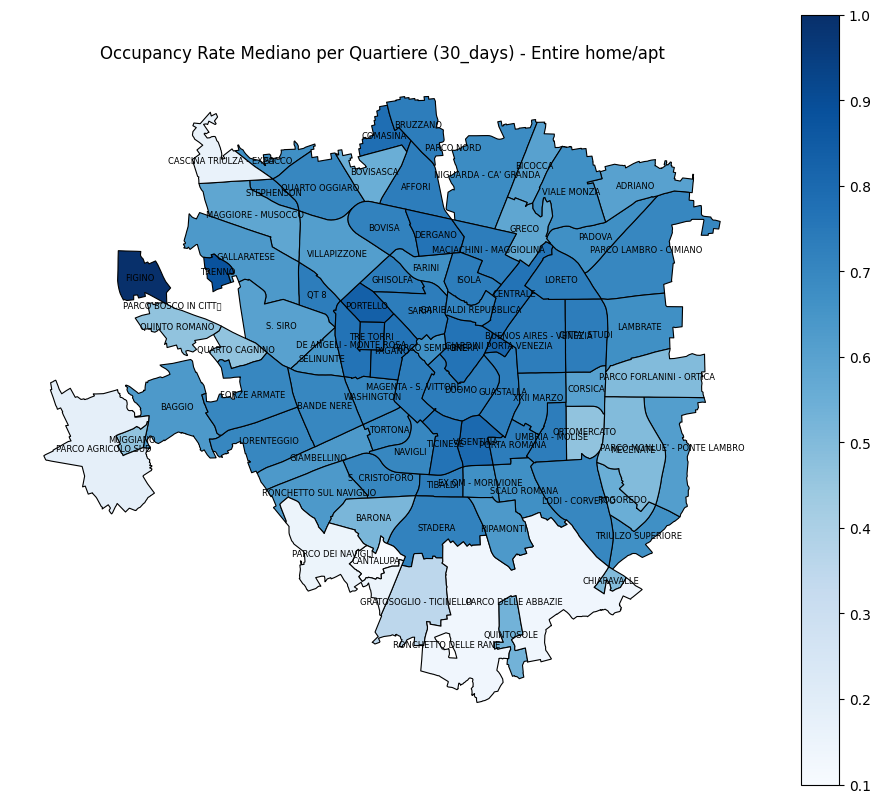

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/4019620641.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


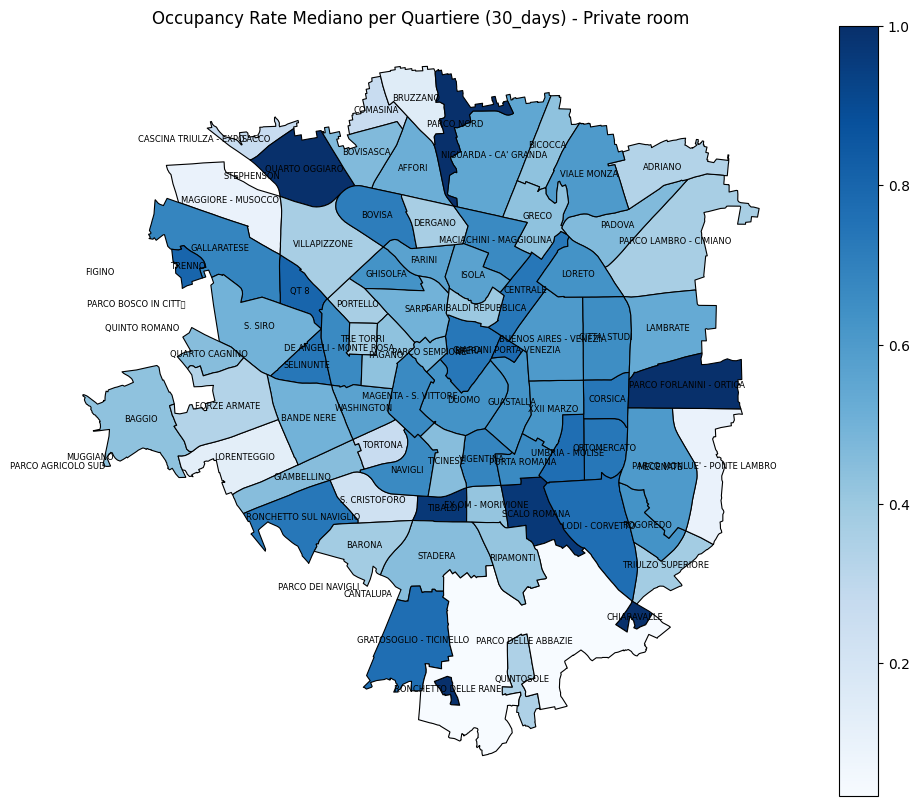

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/4019620641.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/projects_github/airbnb/airbnb-ml-project/ml_project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


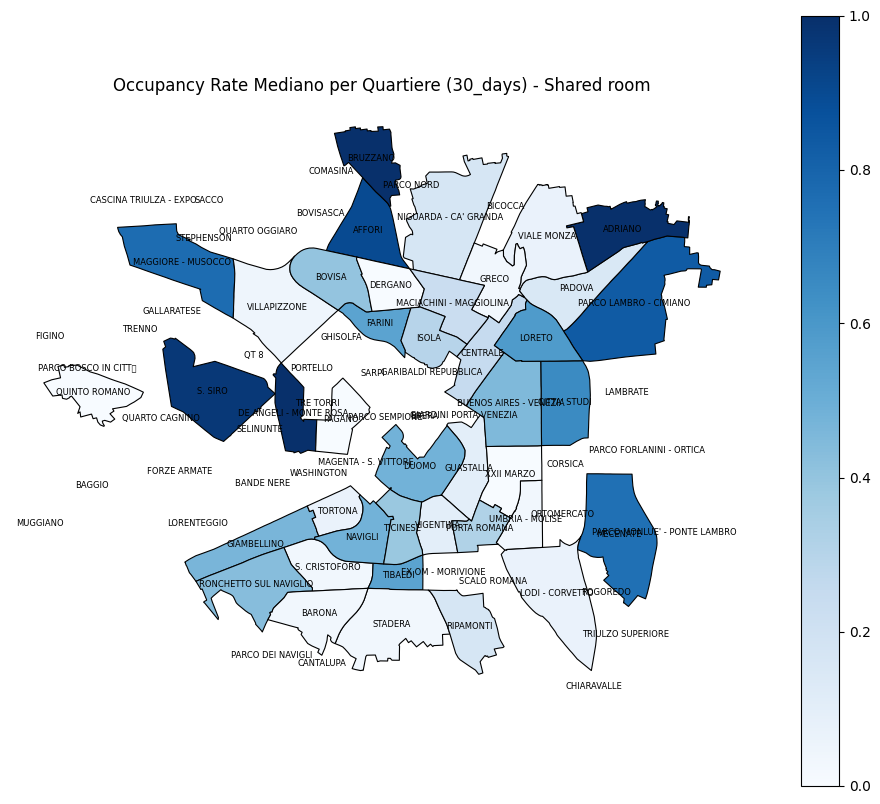

/var/folders/x6/s_m0tn4j3q1c2s5ln0t48dnm0000gn/T/ipykernel_14329/4019620641.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid


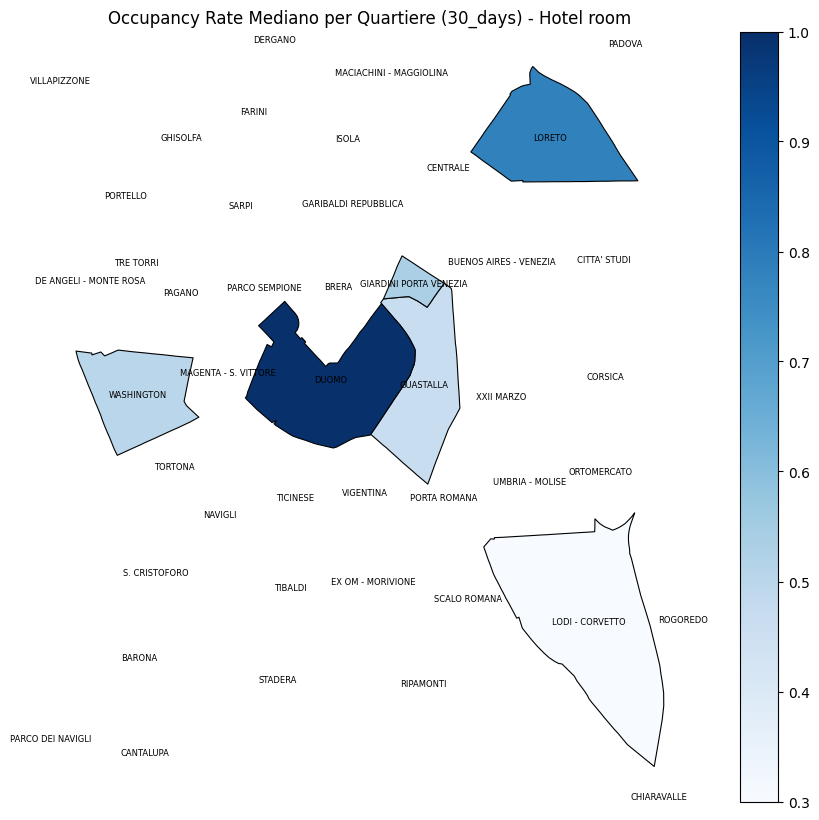

In [16]:
# Estrai le tipologie di stanza uniche
room_types = X_train["room_type"].unique()

for rt in room_types:
    # Filtra i dati per la tipologia di stanza
    subset = X_train[X_train["room_type"] == rt]
    
    # Calcola la mediana di occupancy_rate per quartiere
    avg_occ = subset.groupby("quartiere")["occupancy_rate_30"].median().reset_index()
    avg_occ.columns = ["quartiere", "avg_occupancy"]
    
    # Unisci i dati con il GeoDataFrame
    gdf_merged = gdf.merge(avg_occ, on="quartiere", how="left")
    
    # Facoltativo: se preferisci calcolare i centroidi una sola volta, puoi aggiungere questa colonna
    gdf_merged["centroid"] = gdf_merged.geometry.centroid
    
    # Crea la figura e l'asse
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Crea la mappa tematica
    gdf_merged.plot(
        column="avg_occupancy",
        cmap="Blues",  # scala di blu
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )
    
    # Aggiungi il nome del quartiere usando il centroide per posizionare il testo
    for idx, row in gdf_merged.iterrows():
        # Verifica che la geometria non sia vuota e che il nome del quartiere sia presente
        if not row["geometry"].is_empty and pd.notnull(row["quartiere"]):
            # Puoi usare il centroide calcolato nella colonna oppure calcolarlo direttamente
            centroid = row["centroid"]  # oppure: row["geometry"].centroid
            ax.annotate(
                text=row["quartiere"],
                xy=(centroid.x, centroid.y),
                ha="center",  # centrato orizzontalmente
                va="center",  # centrato verticalmente
                fontsize=6,   # regola la dimensione del font
                color="black"
            )
    
    # Imposta il titolo e rimuovi gli assi
    ax.set_title(f"Occupancy Rate Mediano per Quartiere (30_days) - {rt}")
    ax.axis("off")
    
    # Mostra la figura
    plt.show()


In [ ]:

# 1. Combina X_train e y_train
df_train = pd.concat([X_train, y_train.rename("price")], axis=1)

def remove_outliers(df, column, factor=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_train = remove_outliers(df_train, "price", factor=1.5)

# 3. Separa di nuovo le feature (X) dal target (y)
X_train = df_train.drop(columns="price")
y_train = df_train["price"]


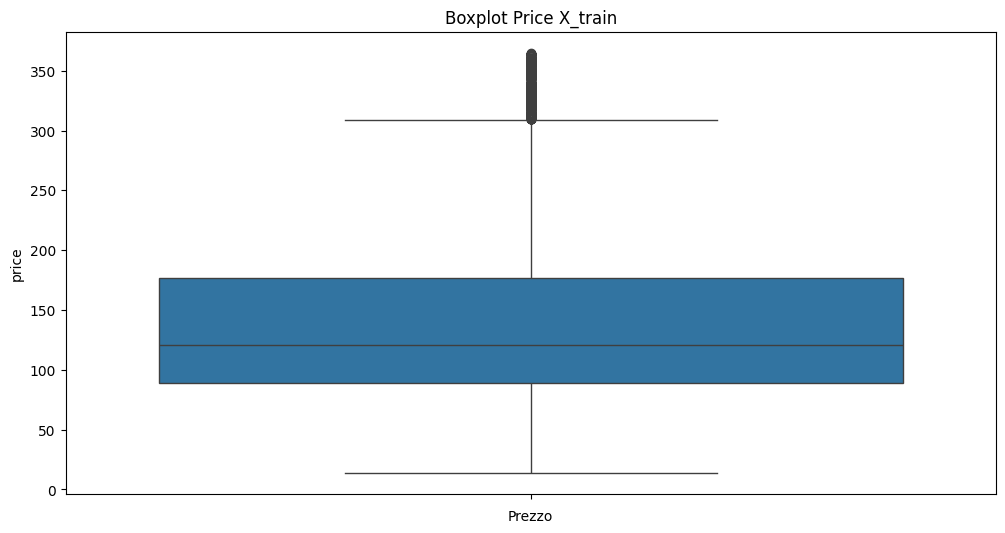

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(y_train)
plt.title("Boxplot Price X_train")
plt.xlabel("Prezzo")
plt.show()


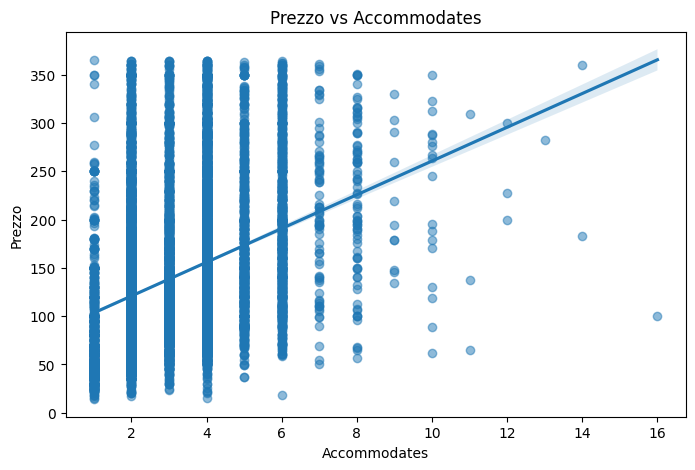

In [20]:
plt.figure(figsize=(8,5))
sns.regplot(x=X_train['accommodates'], y=y_train, scatter_kws={"alpha":0.5})
plt.title("Prezzo vs Accommodates")
plt.xlabel("Accommodates")
plt.ylabel("Prezzo")
plt.show()


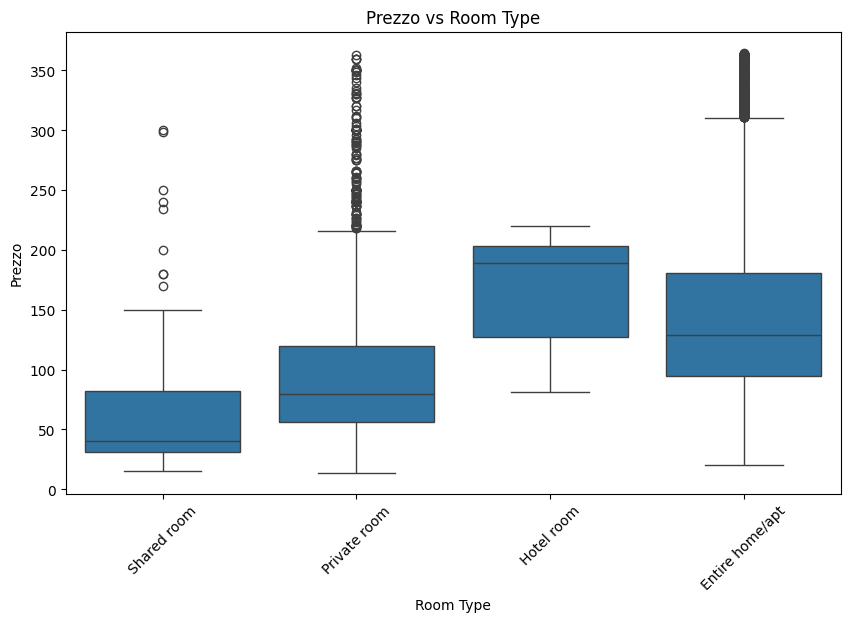

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x=X_train['room_type'], y=y_train)
plt.title("Prezzo vs Room Type")
plt.xlabel("Room Type")
plt.ylabel("Prezzo")
plt.xticks(rotation=45)
plt.show()


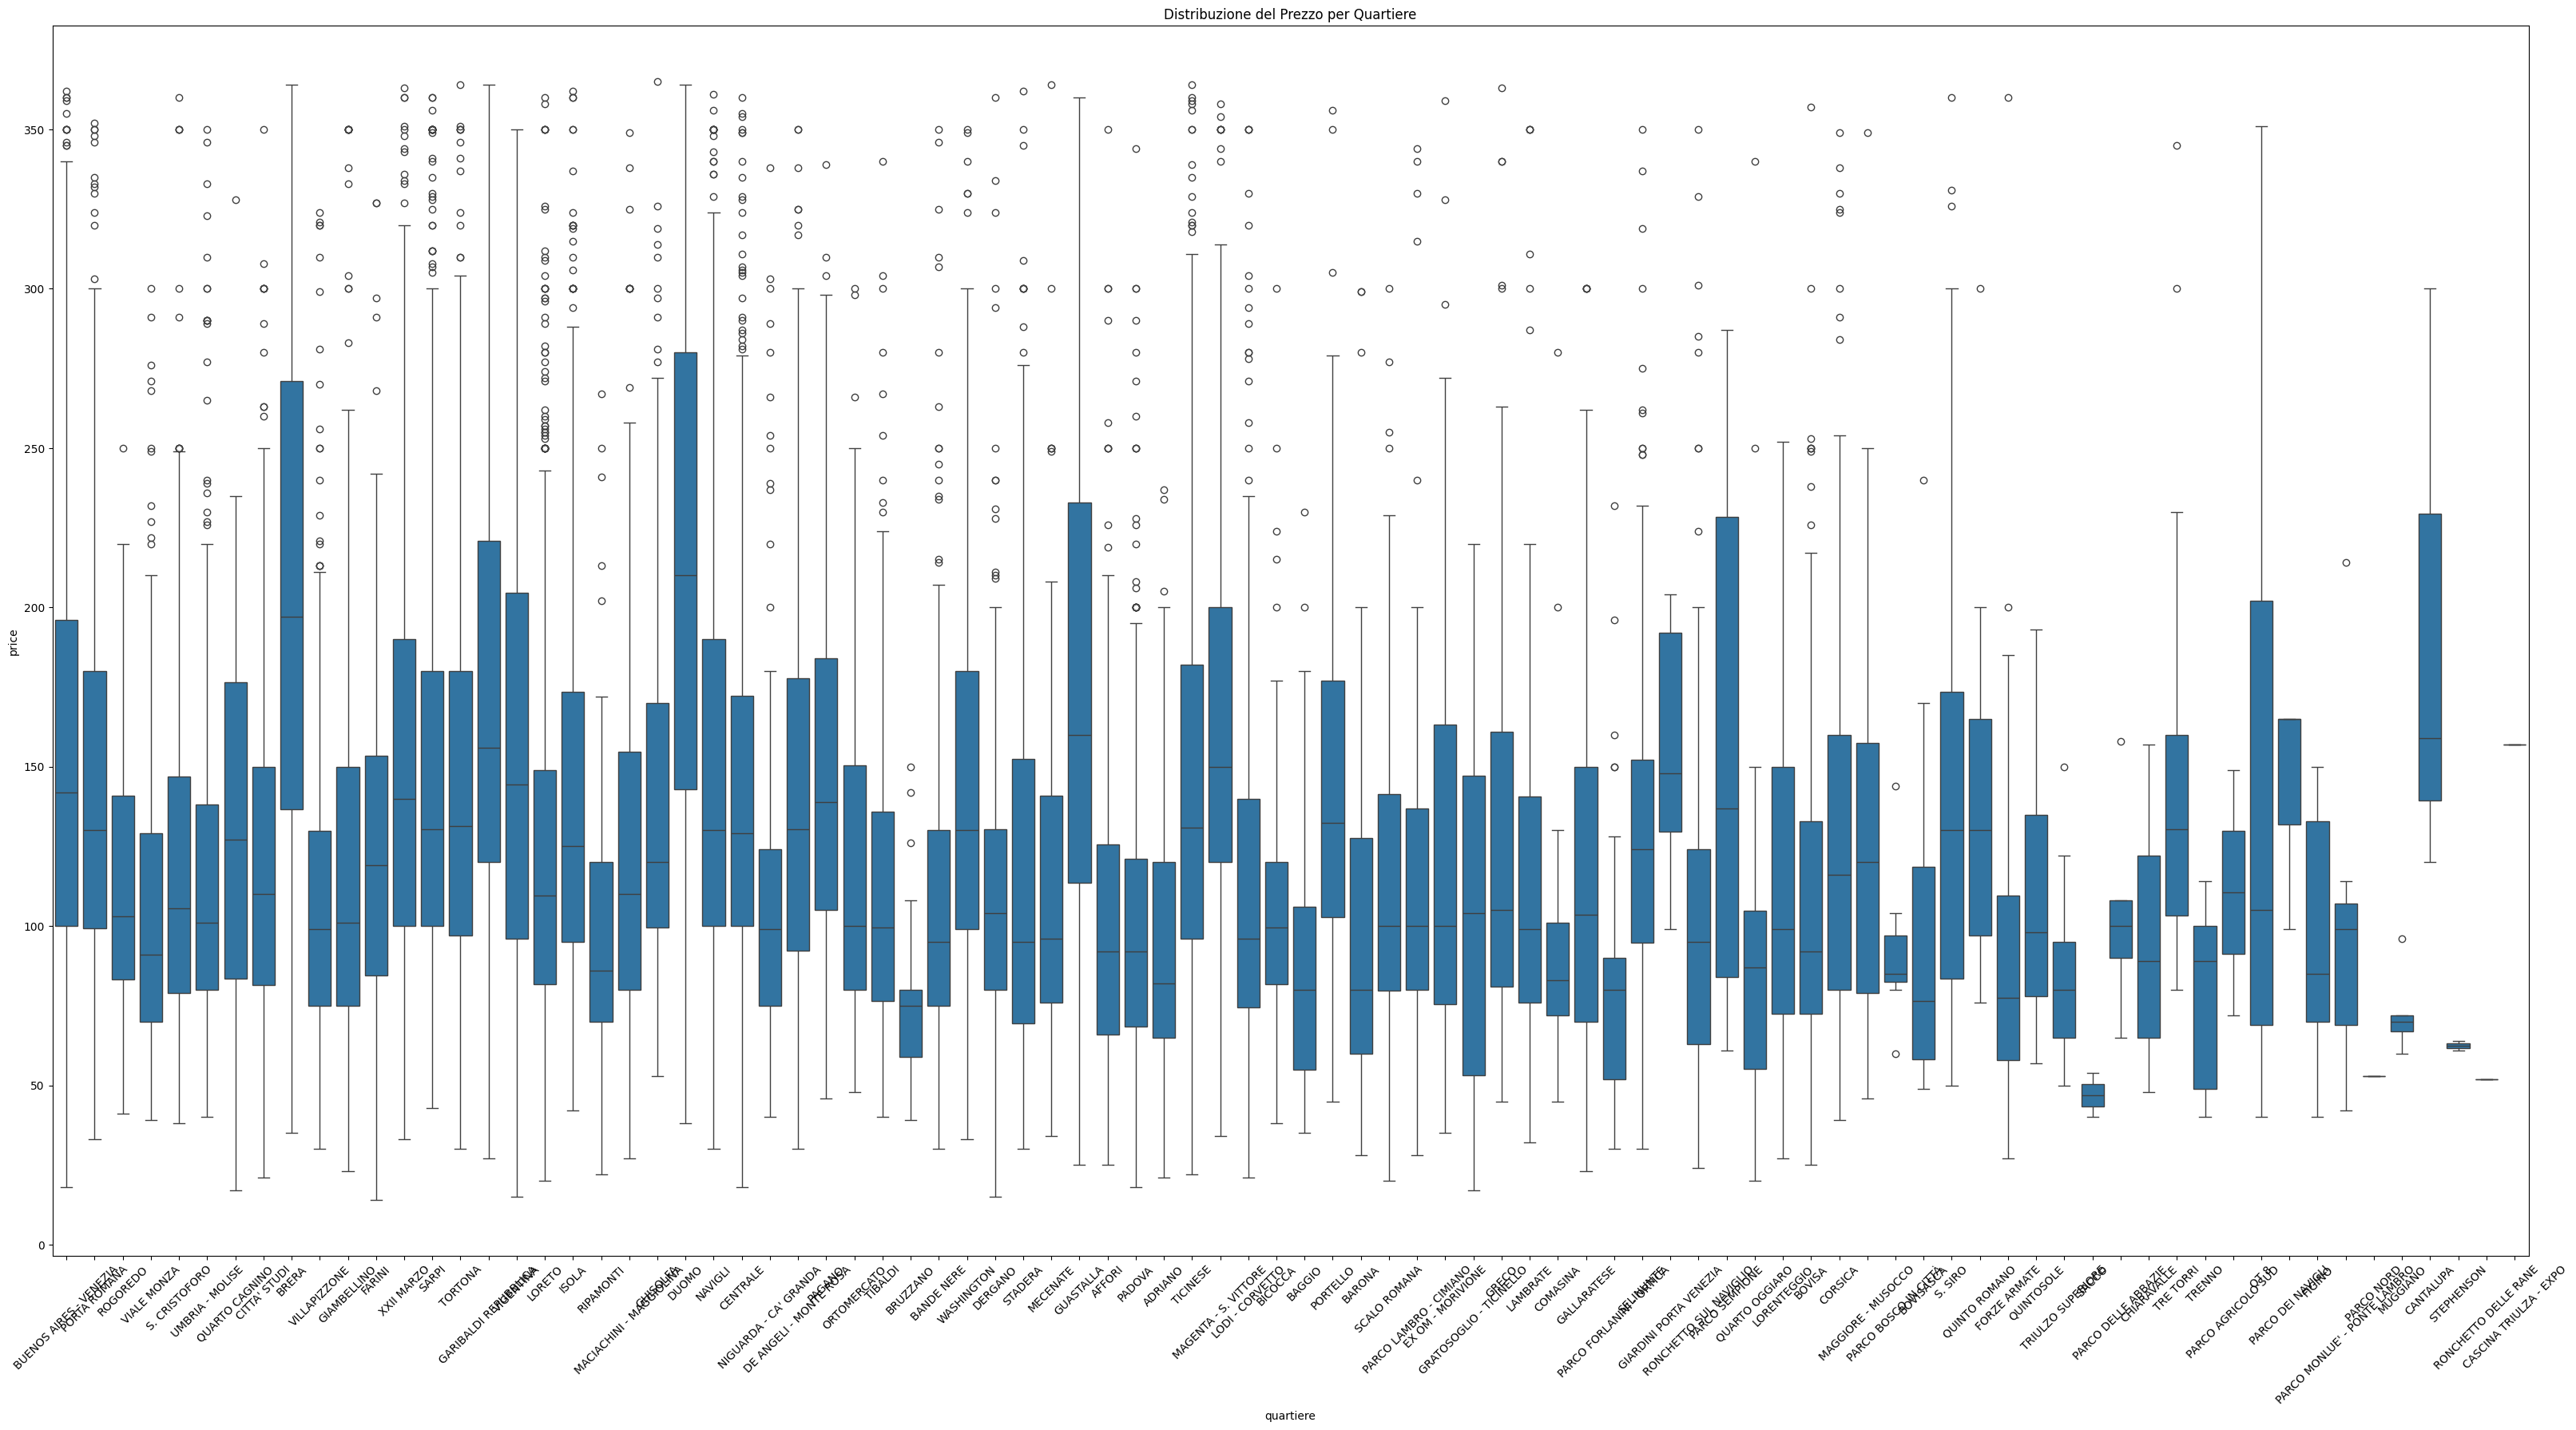

In [ ]:
plt.figure(figsize=(40, 20))
sns.boxplot(data=df_price, x="quartiere", y="price")
plt.title("Distribuzione del Prezzo per Quartiere")
plt.xticks(rotation=45)  # Ruota le etichette se i nomi dei quartieri sono lunghi
plt.show()


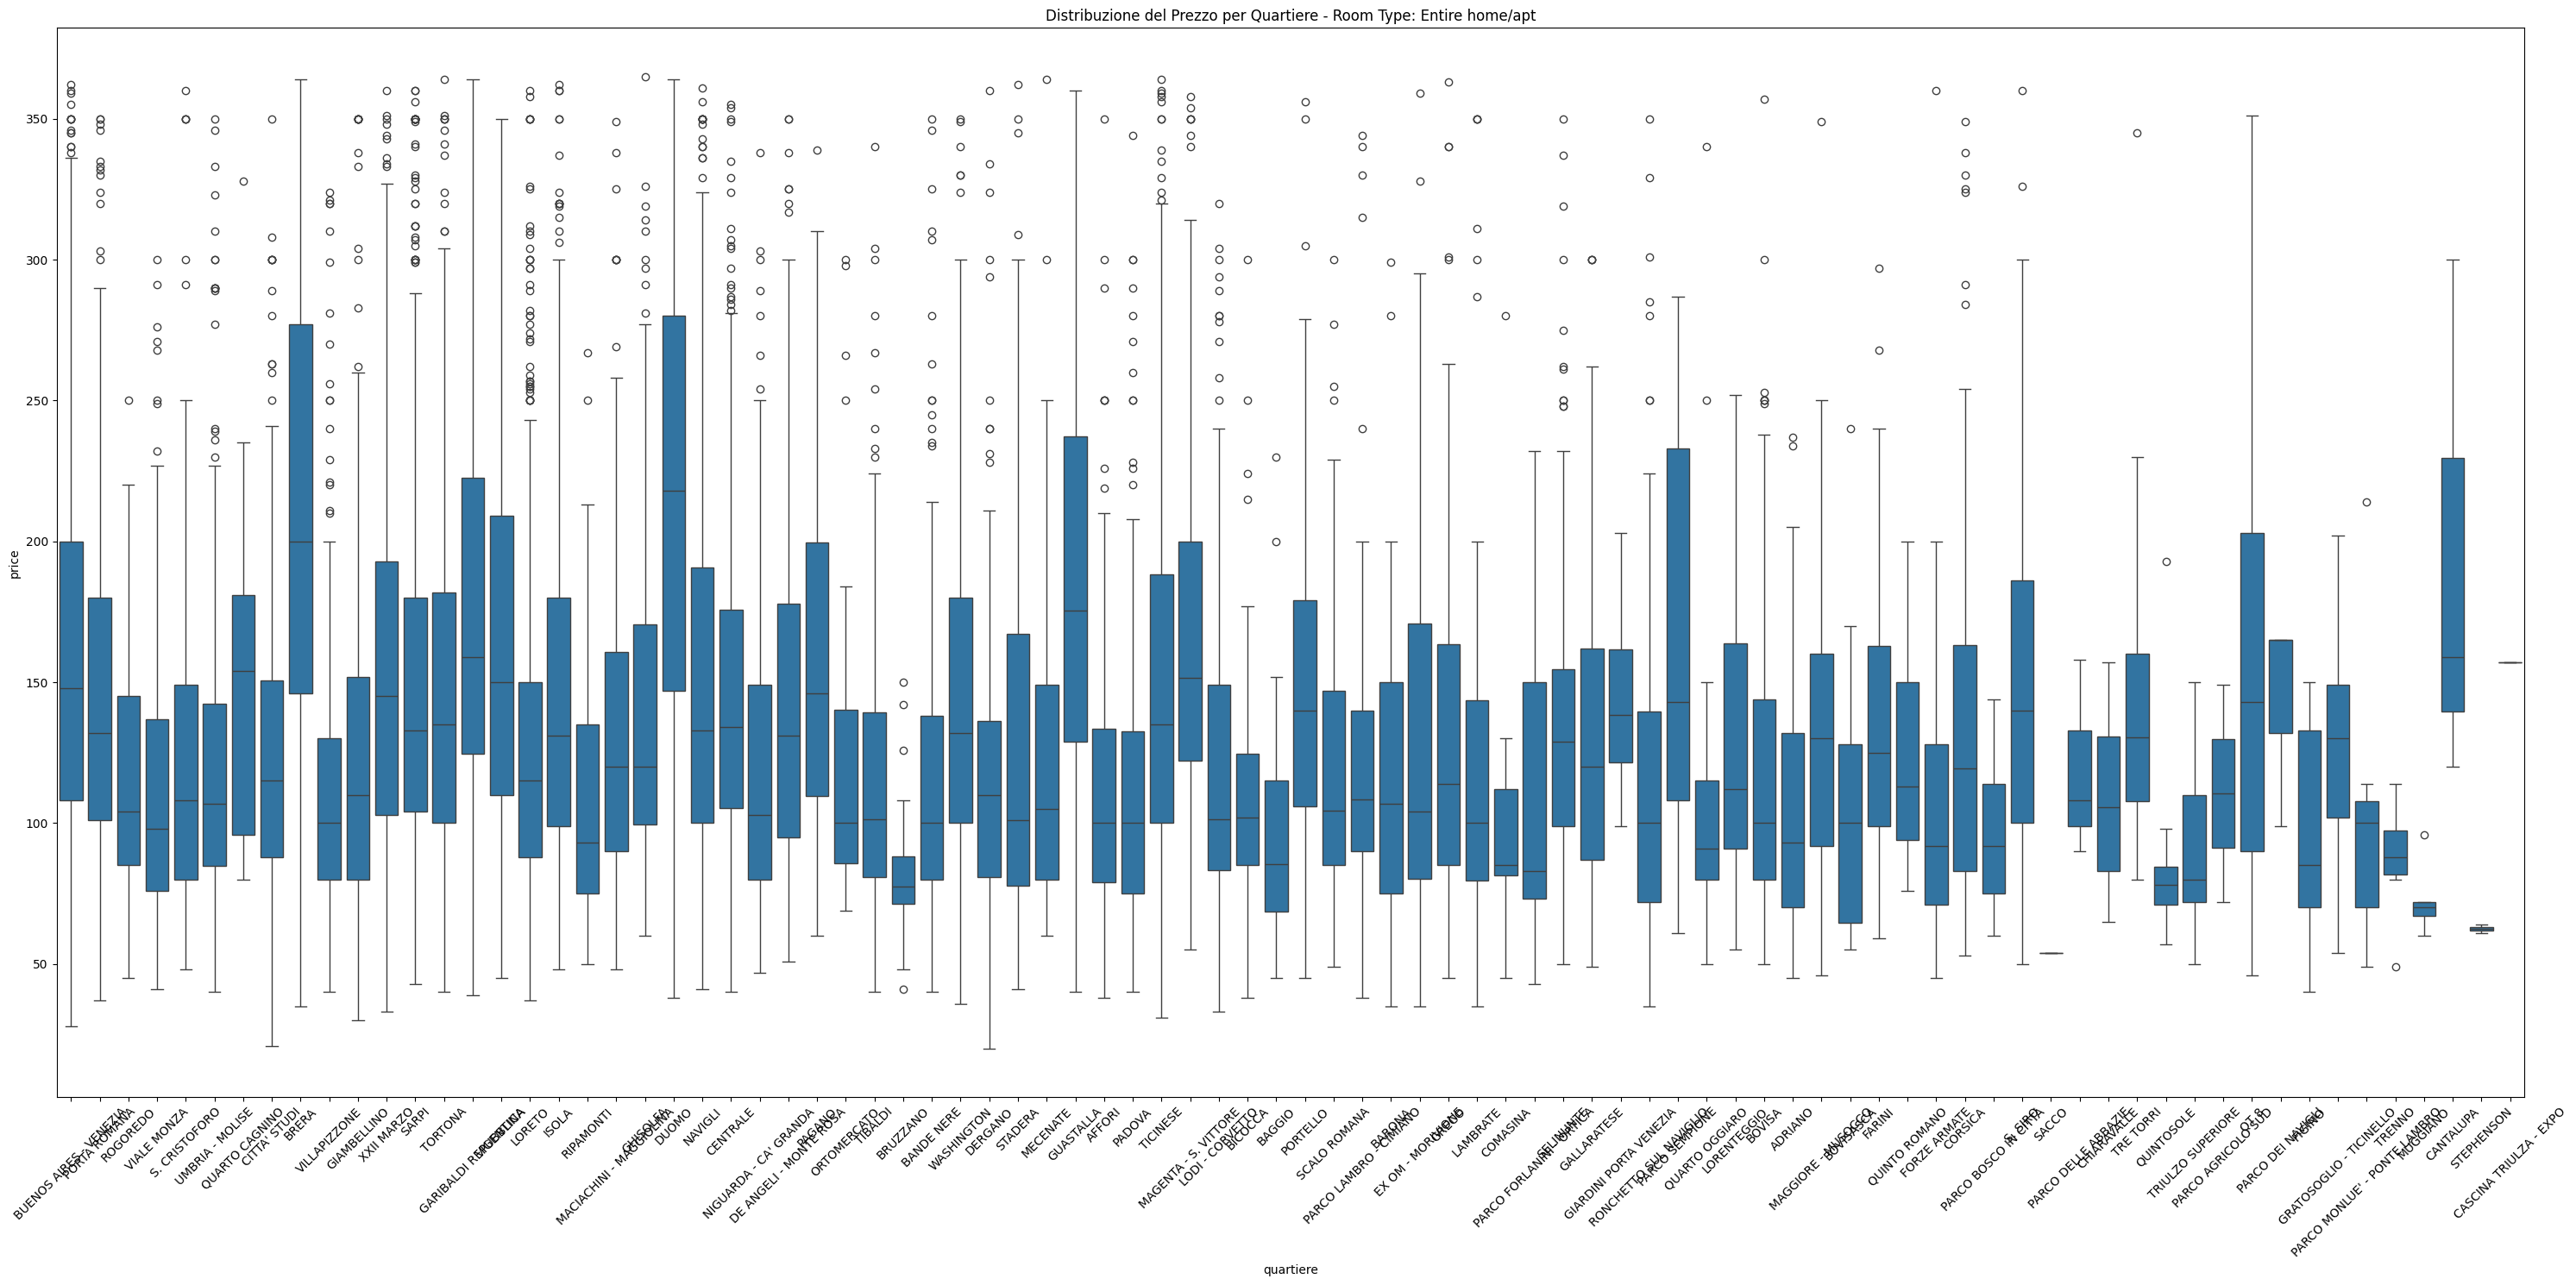

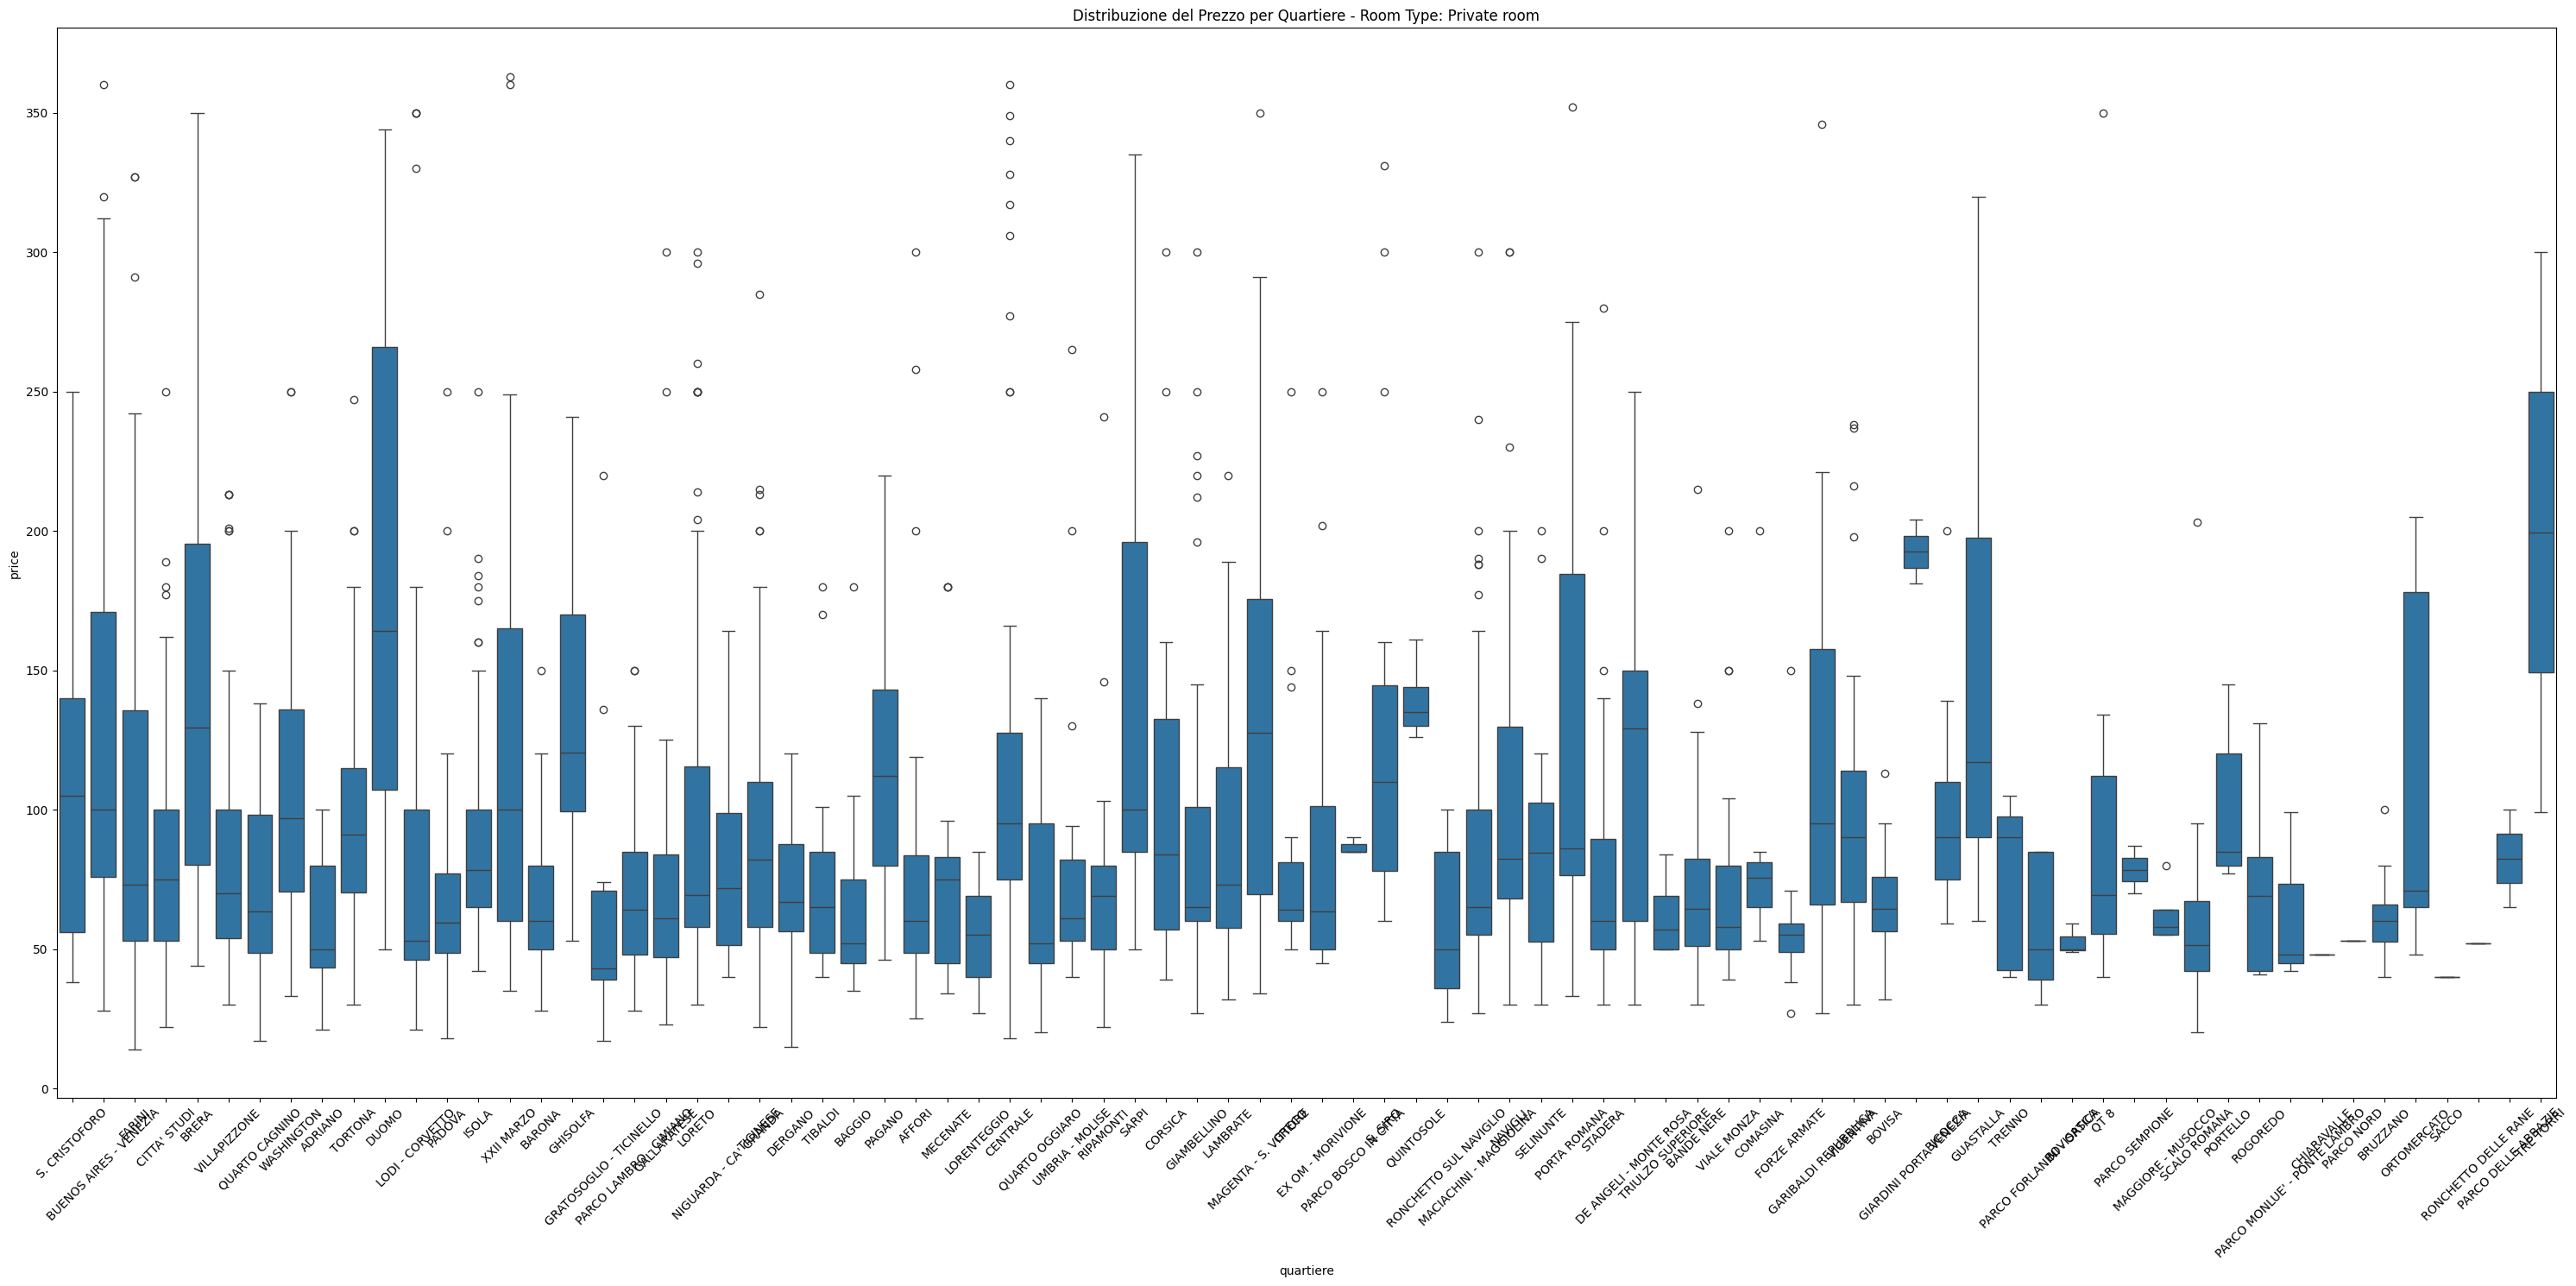

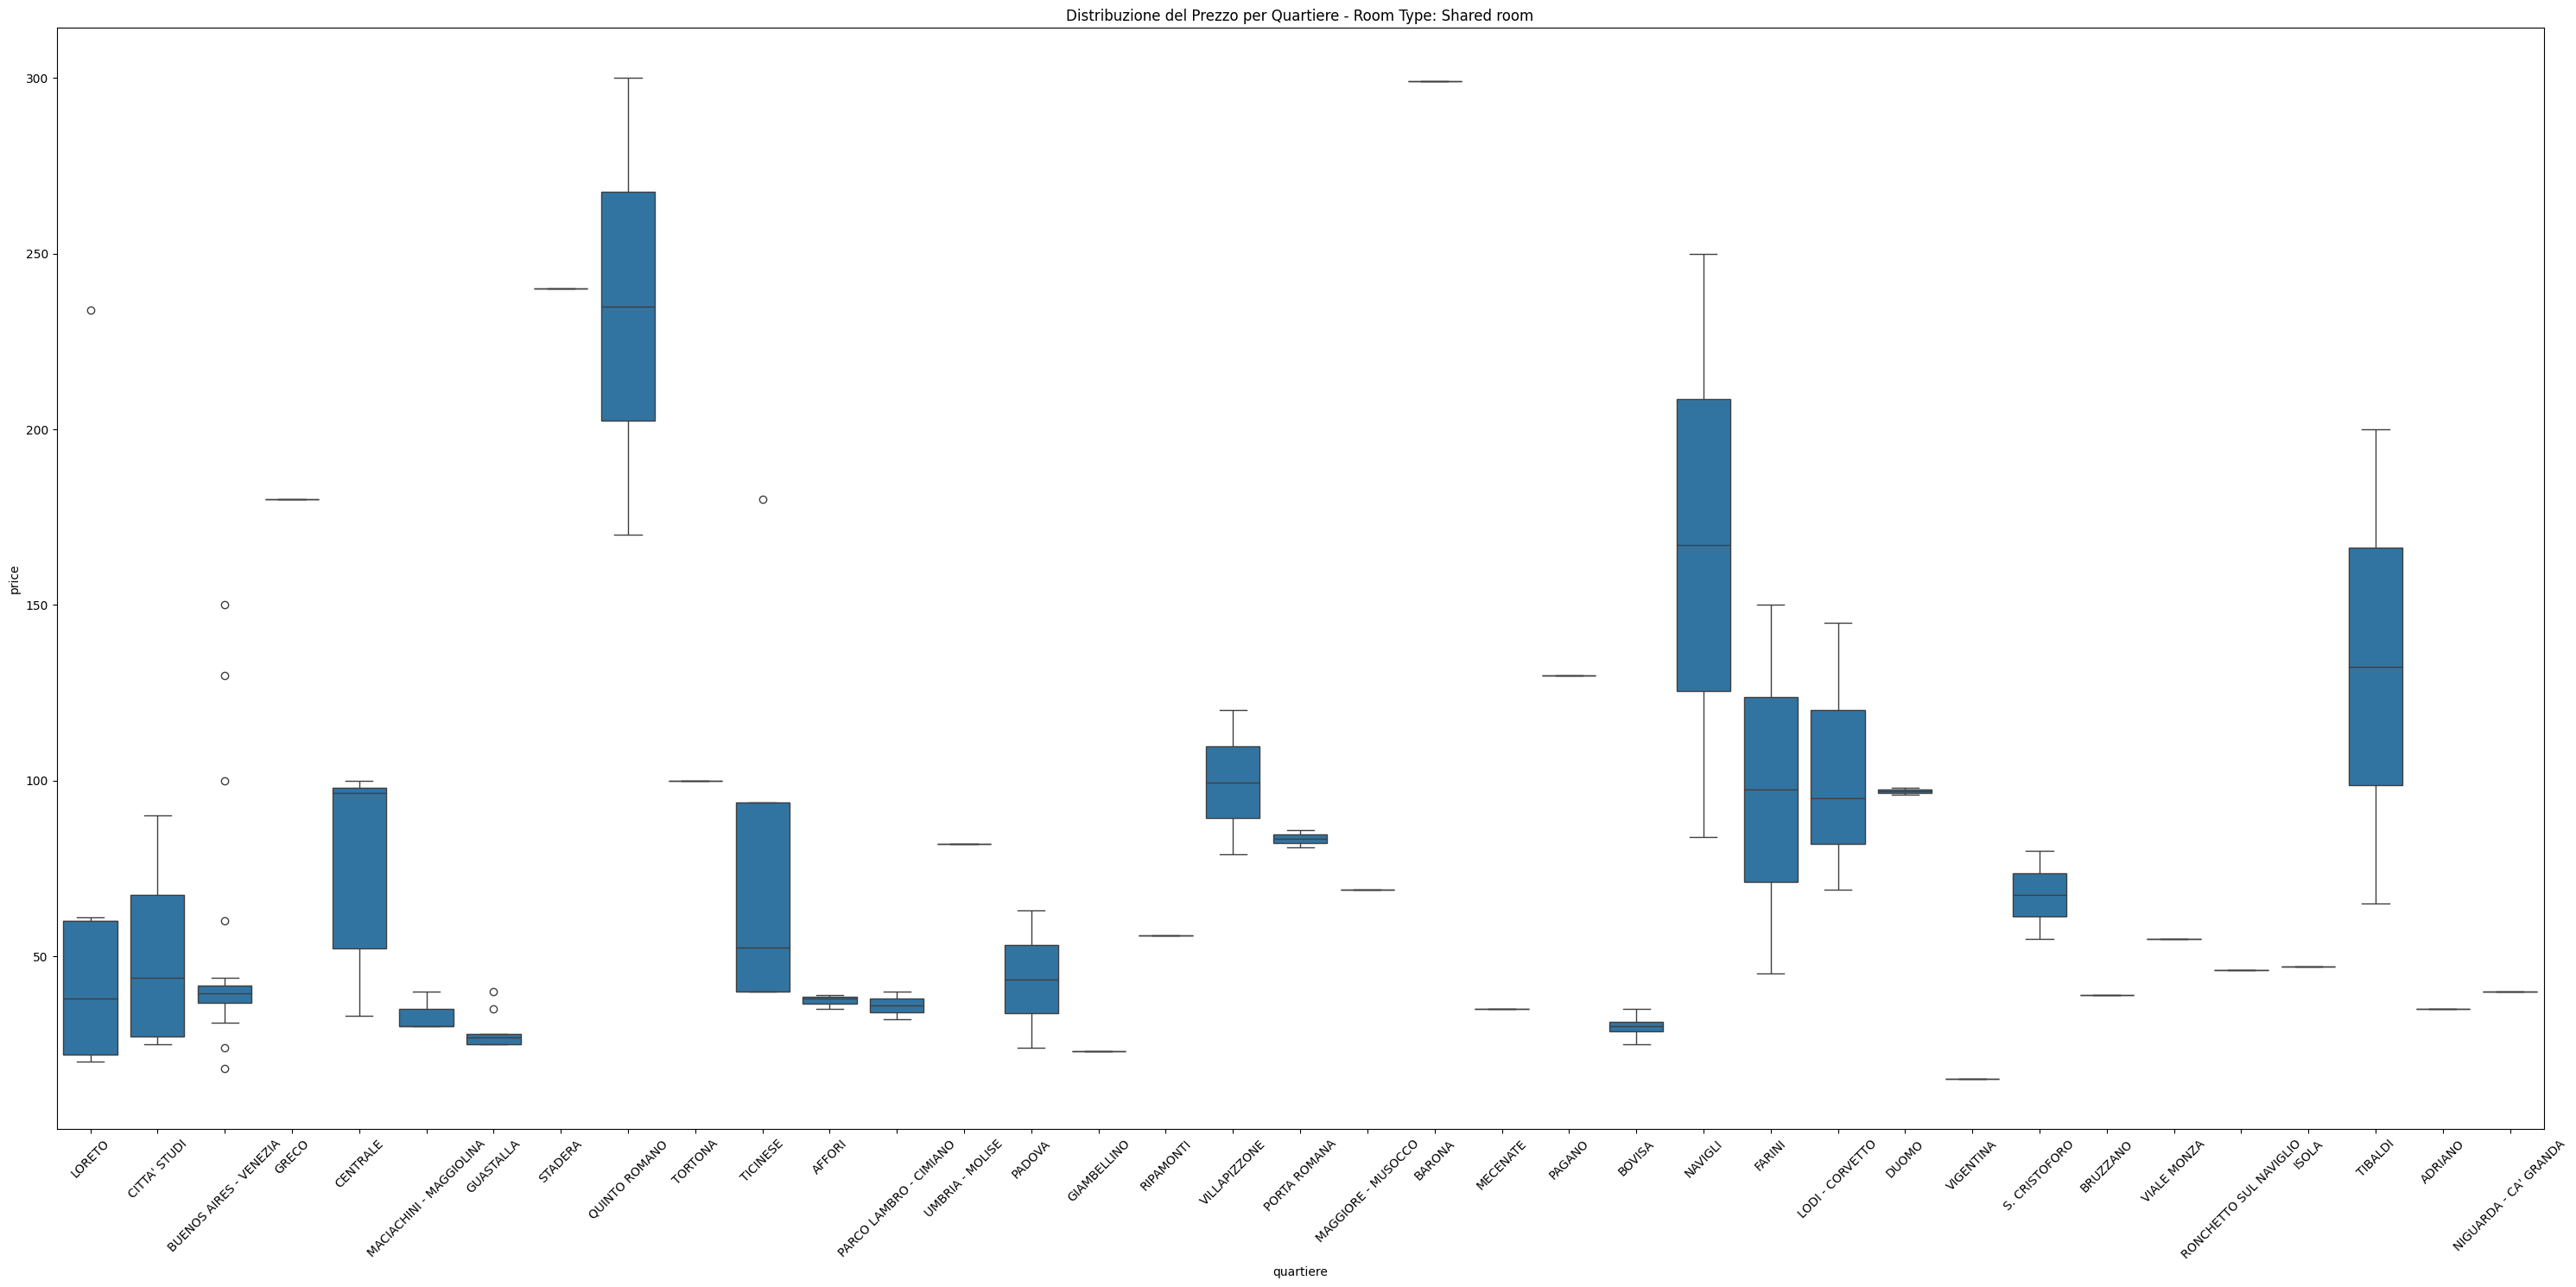

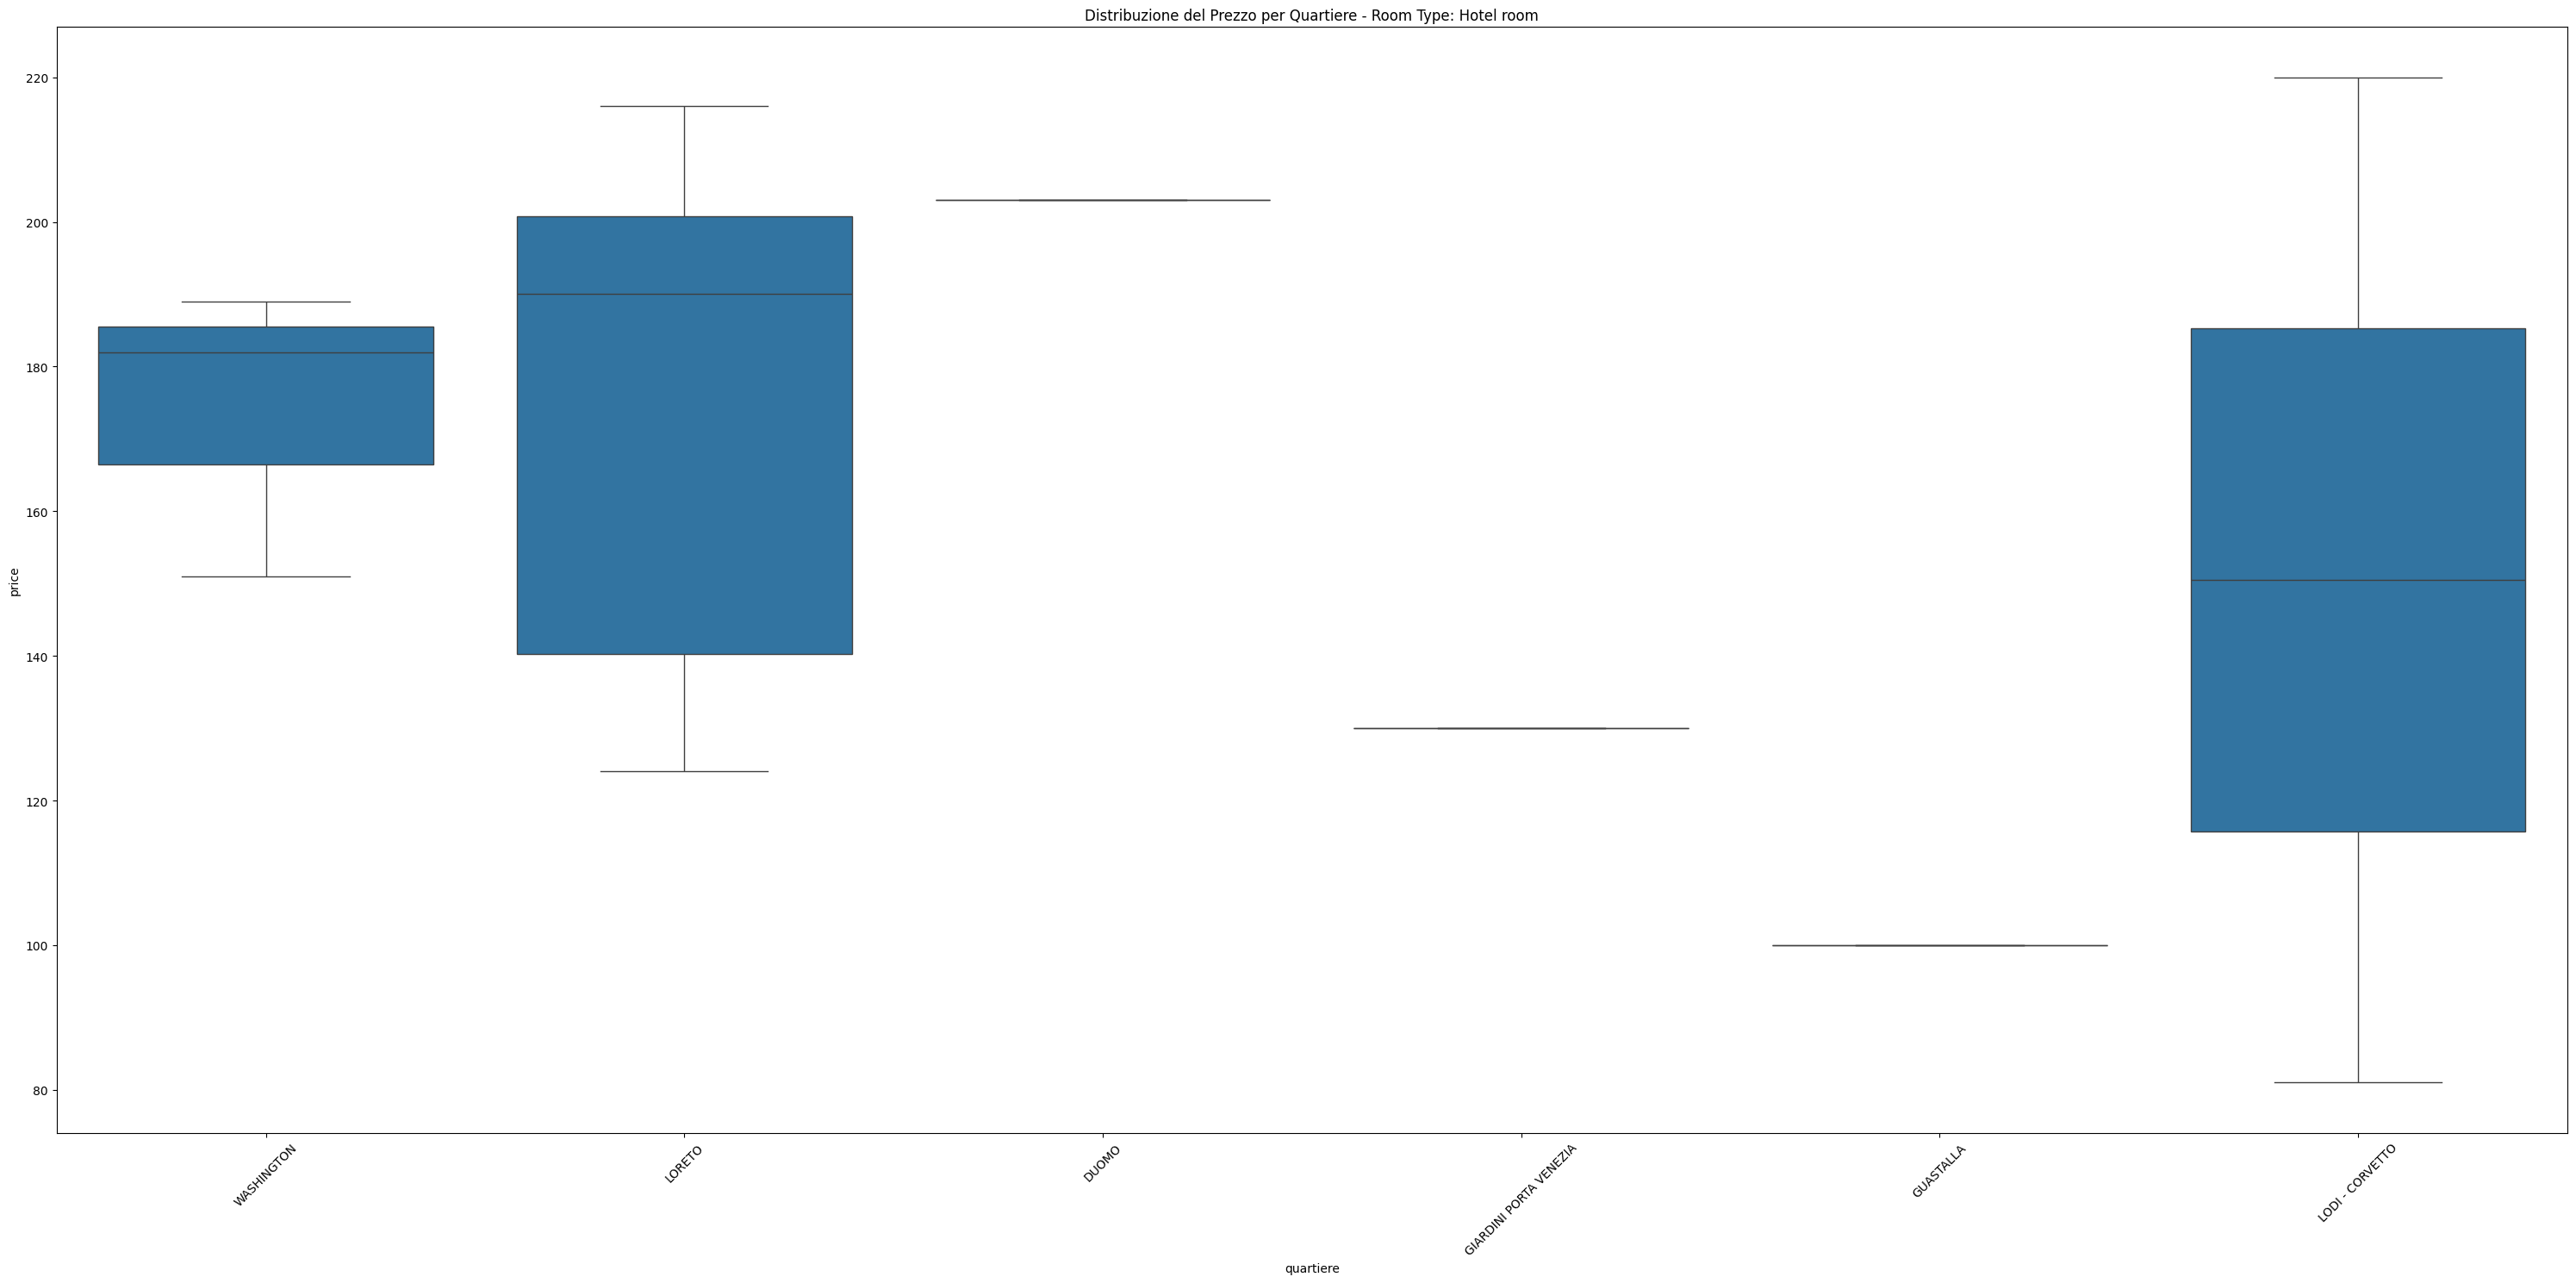

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ottieni i valori unici di room_type
room_types = df_price["room_type"].unique()

for rt in room_types:
    # Filtra il DataFrame per il room_type corrente
    subset = df_price[df_price["room_type"] == rt]
    
    # Crea una nuova figura per ogni room_type
    plt.figure(figsize=(30, 15))
    sns.boxplot(data=subset, x="quartiere", y="price")
    plt.title(f"Distribuzione del Prezzo per Quartiere - Room Type: {rt}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


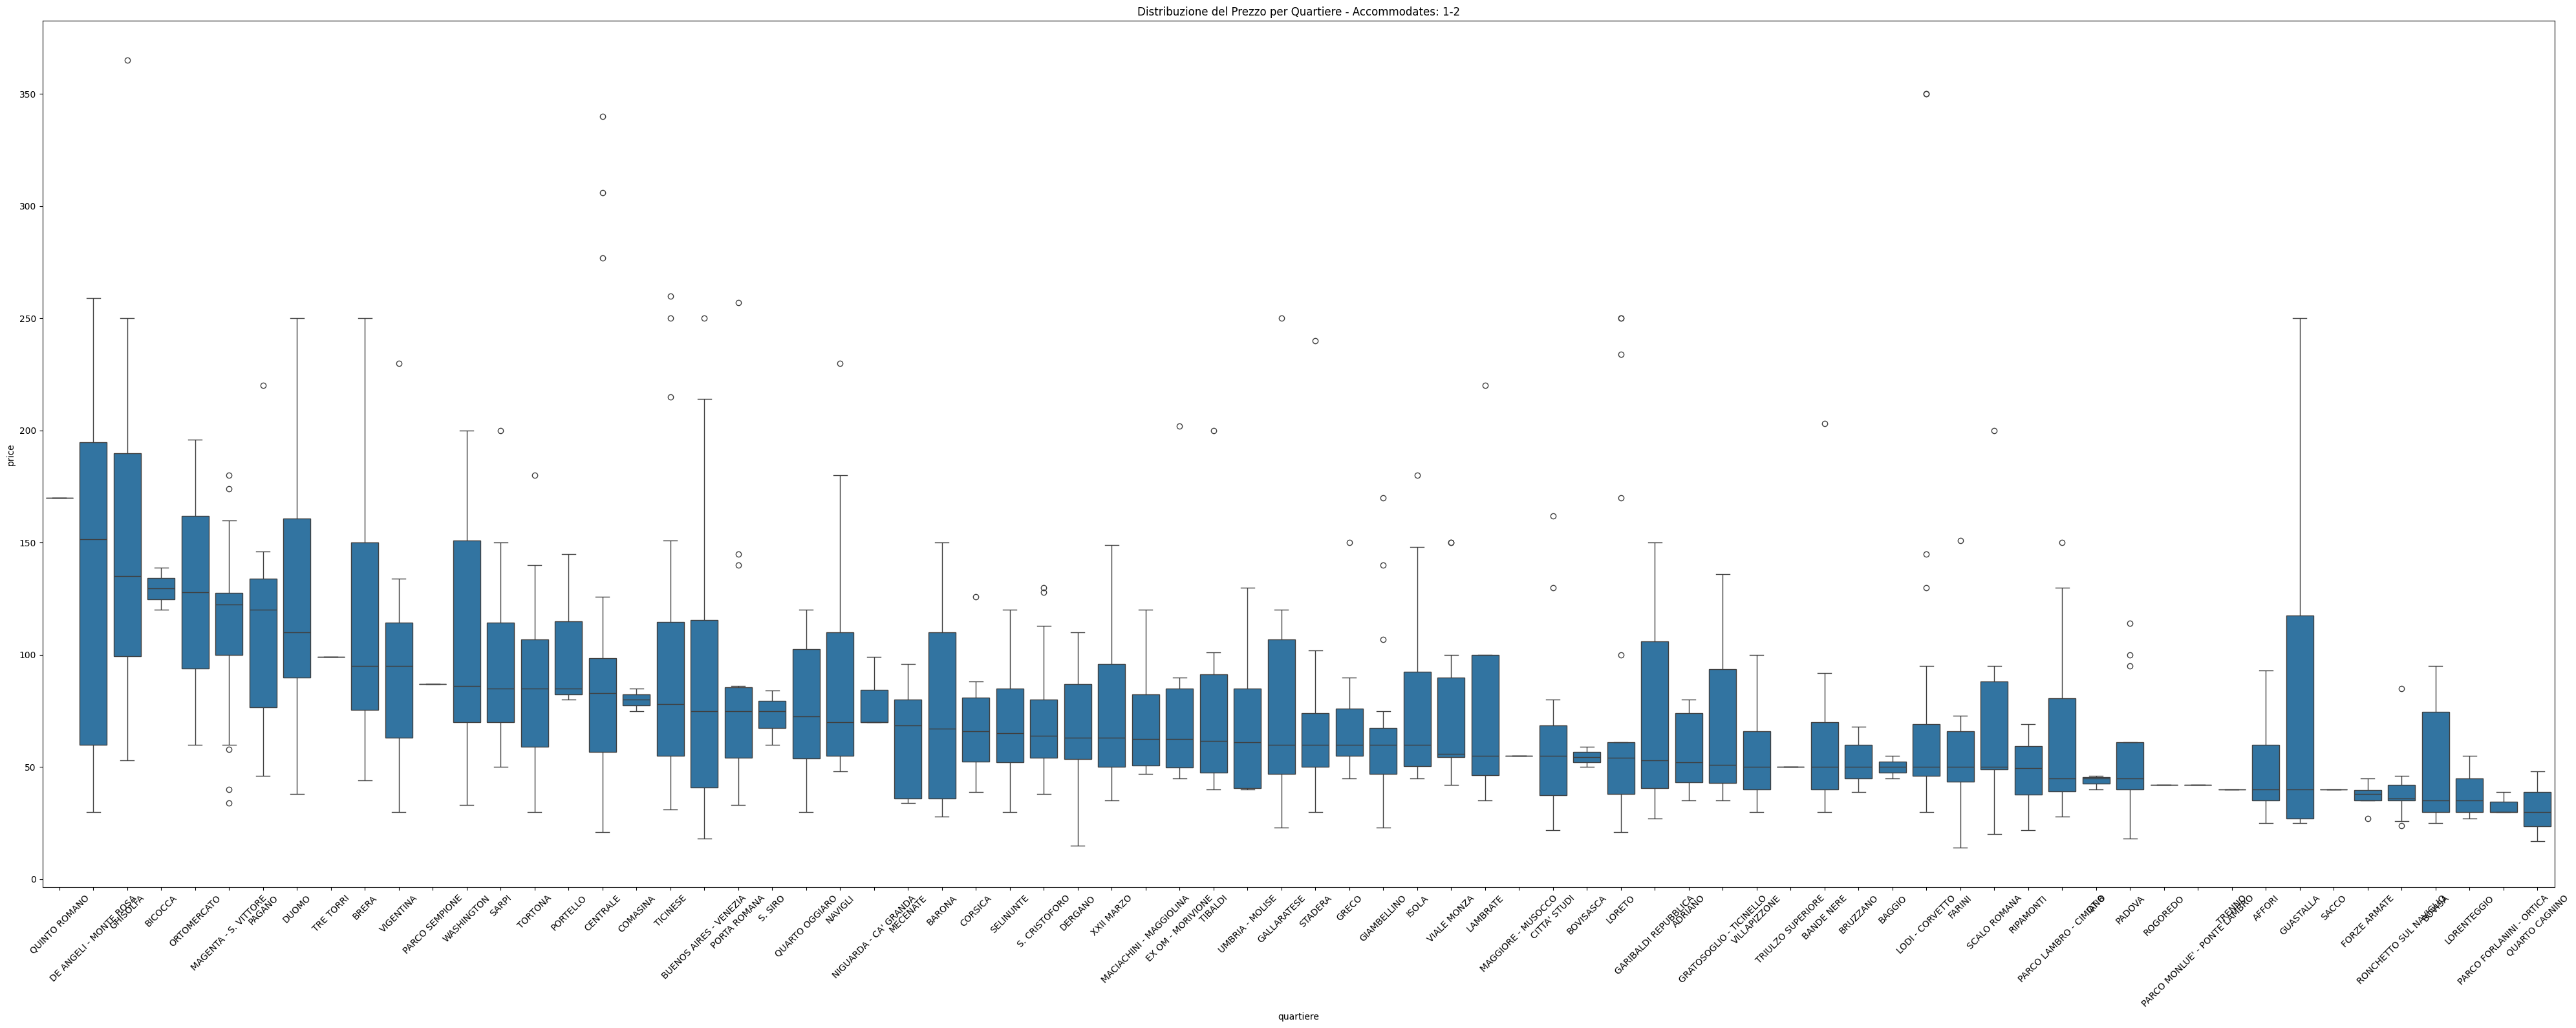

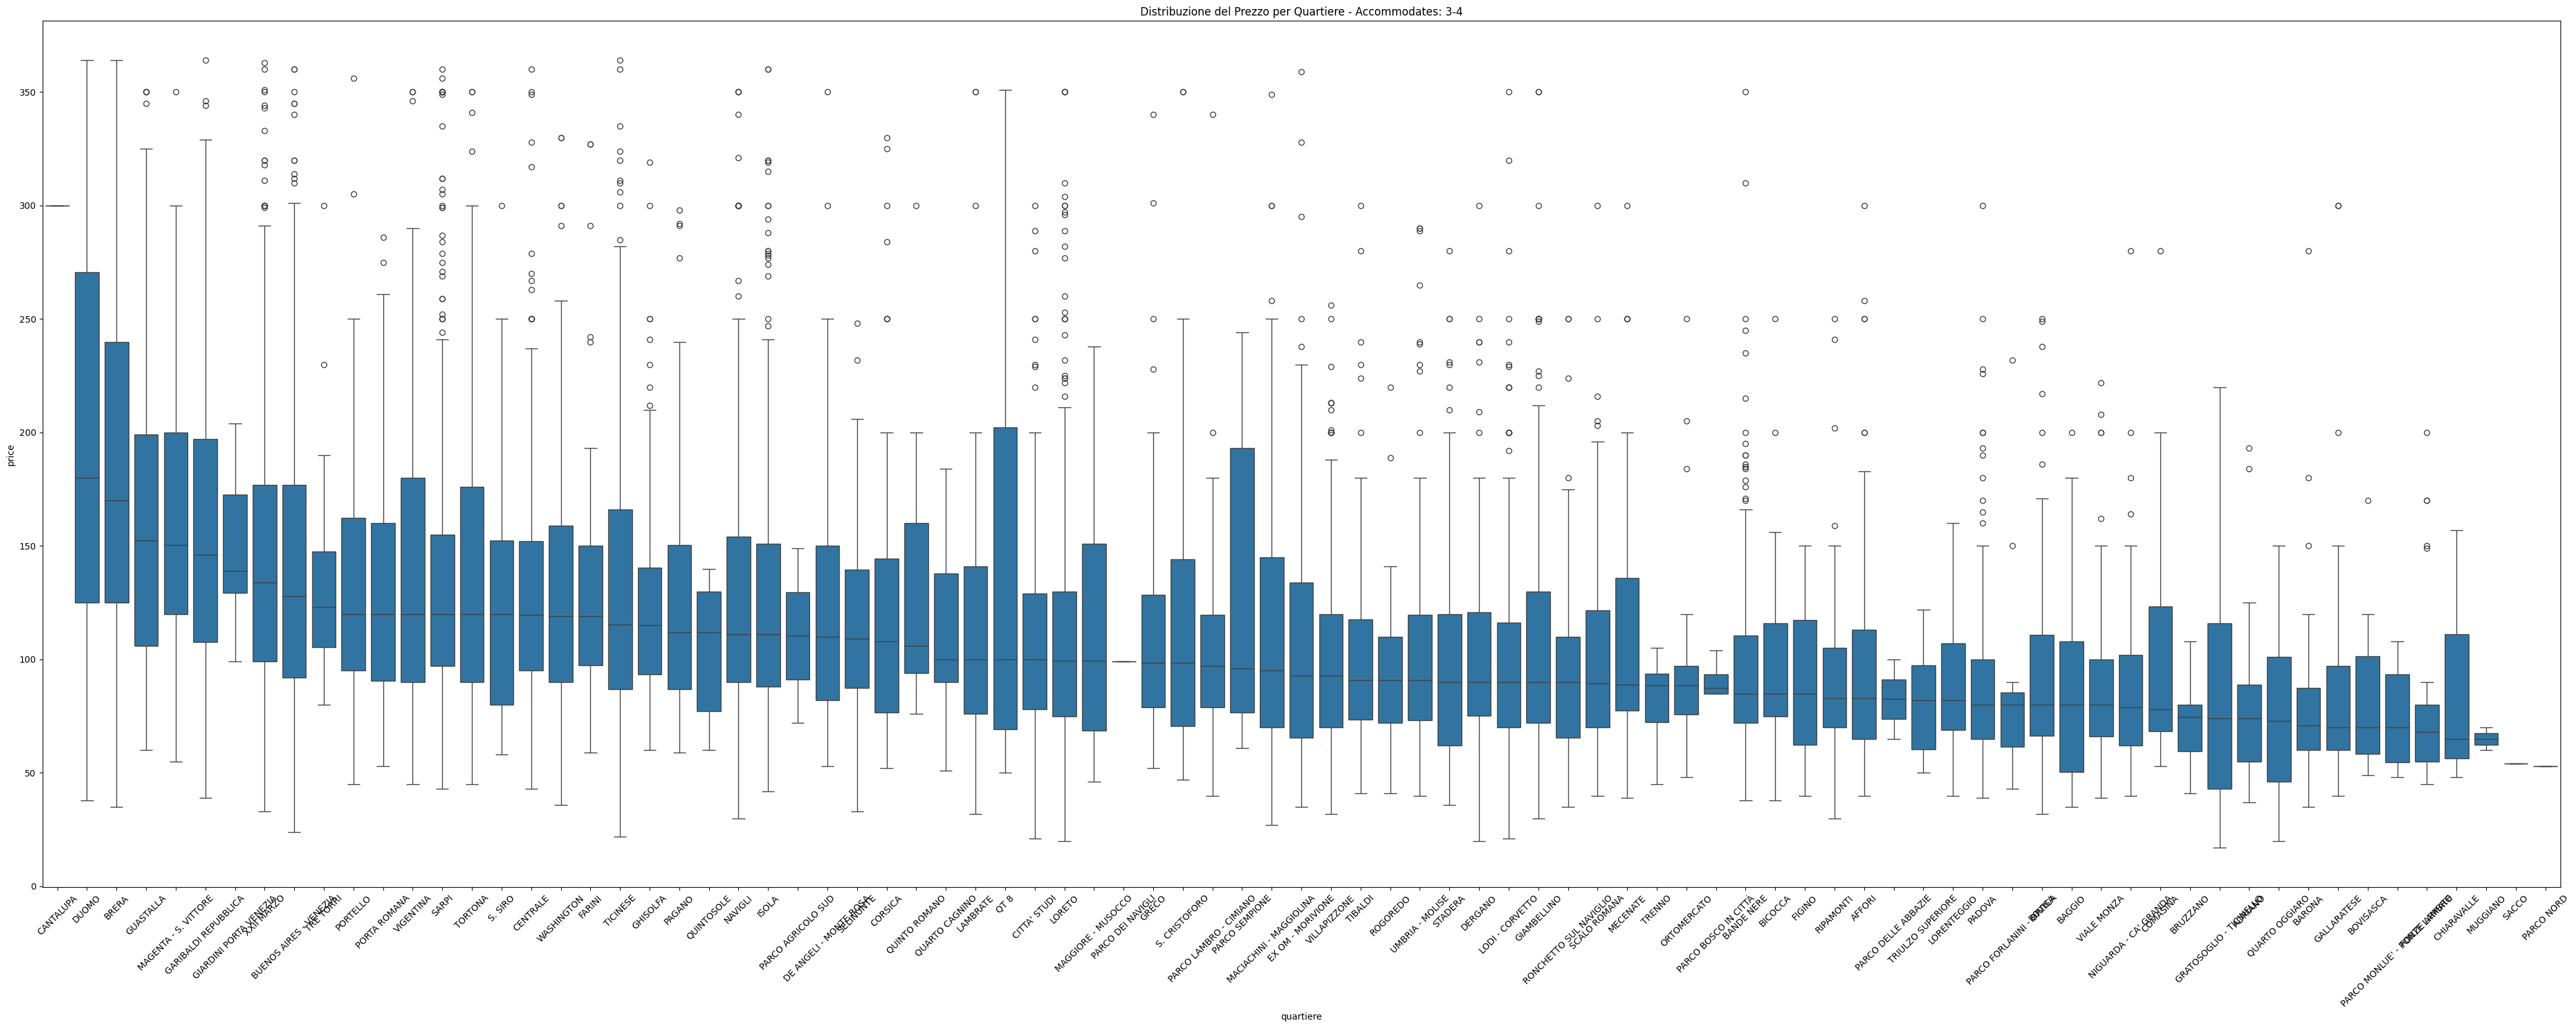

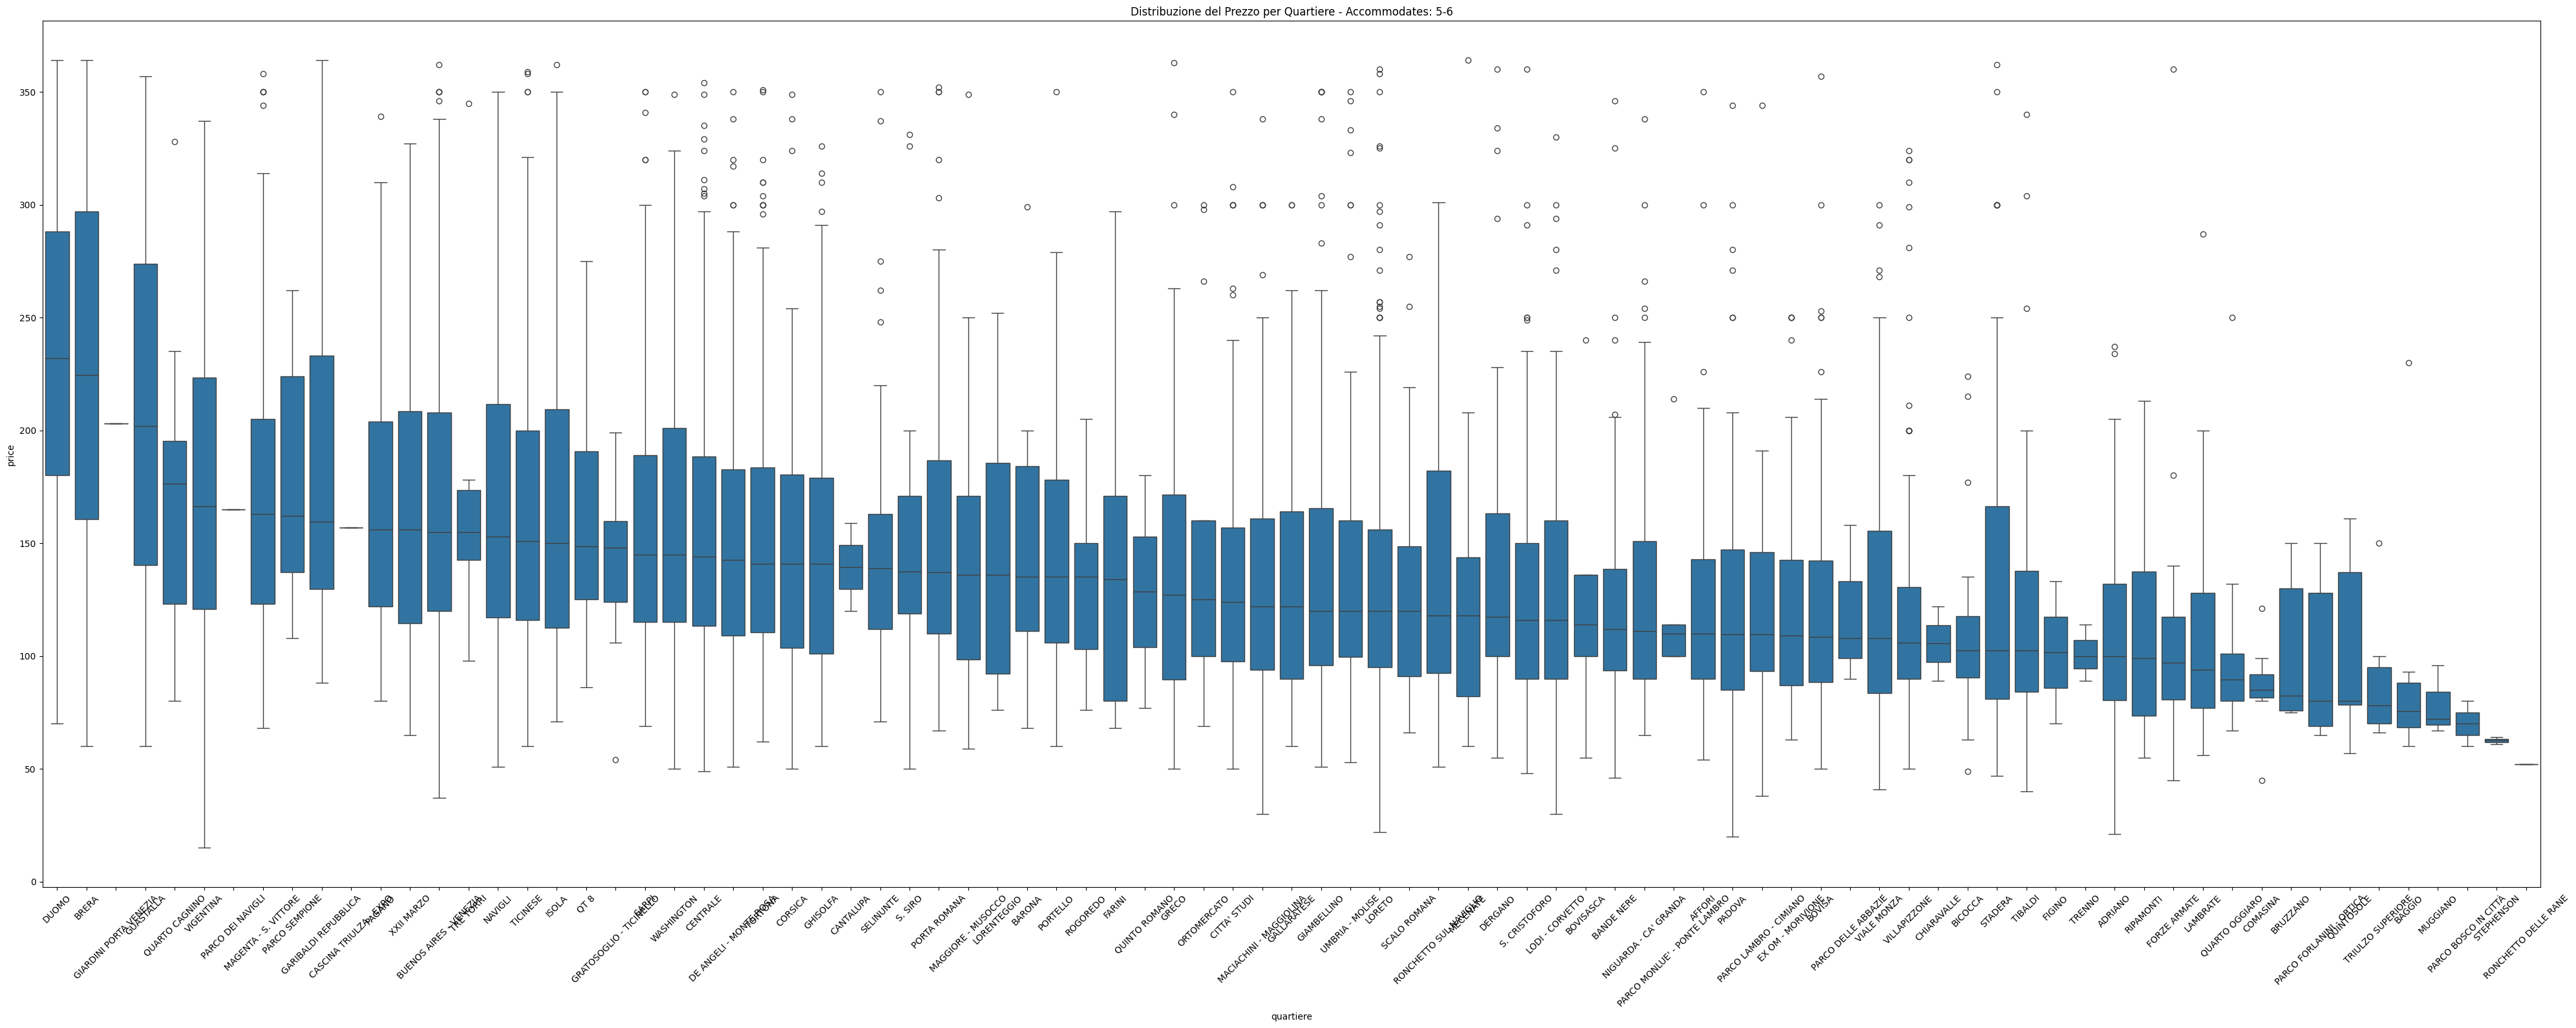

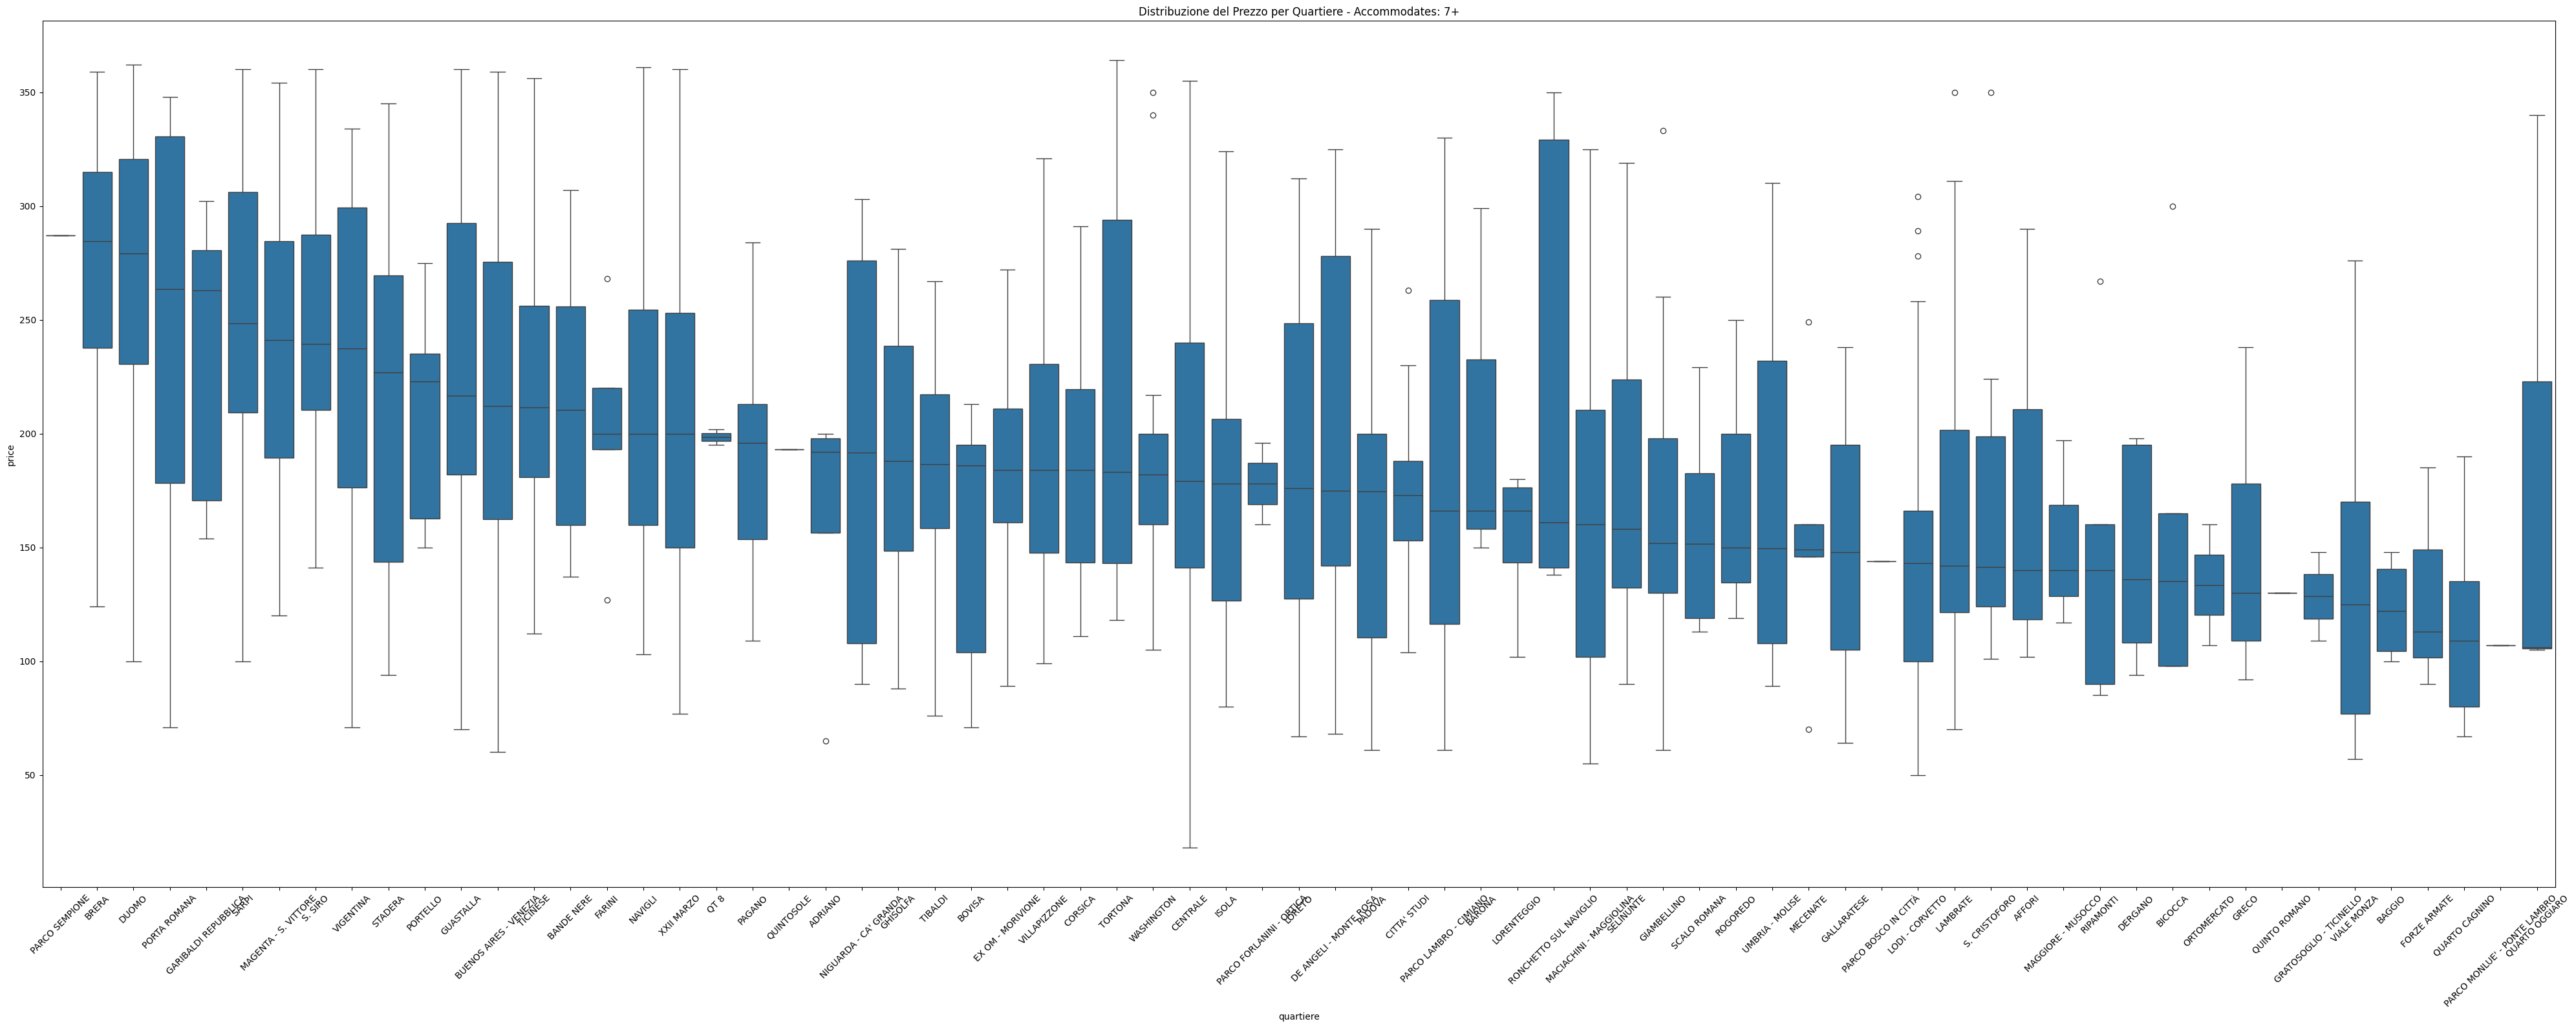

In [140]:
# Lista ordinata dei bin per accommodates (assicurati che siano categorizzati in ordine)
labels = ['1-2', '3-4', '5-6', '7+']
df_price['accommodates_bin'] = pd.Categorical(df_price['accommodates_bin'], categories=labels, ordered=True)

# Itera per ogni categoria di accommodates_bin e crea un boxplot separato
for bin_label in labels:
    subset = df_price[df_price['accommodates_bin'] == bin_label]
    
    # Calcola l'ordine dei quartieri in base alla mediana del prezzo (dal più costoso al meno costoso)
    quartiere_order = subset.groupby("quartiere")["price"].median().sort_values(ascending=False).index

    plt.figure(figsize=(40, 16))
    sns.boxplot(data=subset, x="quartiere", y="price", order=quartiere_order)
    plt.title(f"Distribuzione del Prezzo per Quartiere - Accommodates: {bin_label}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


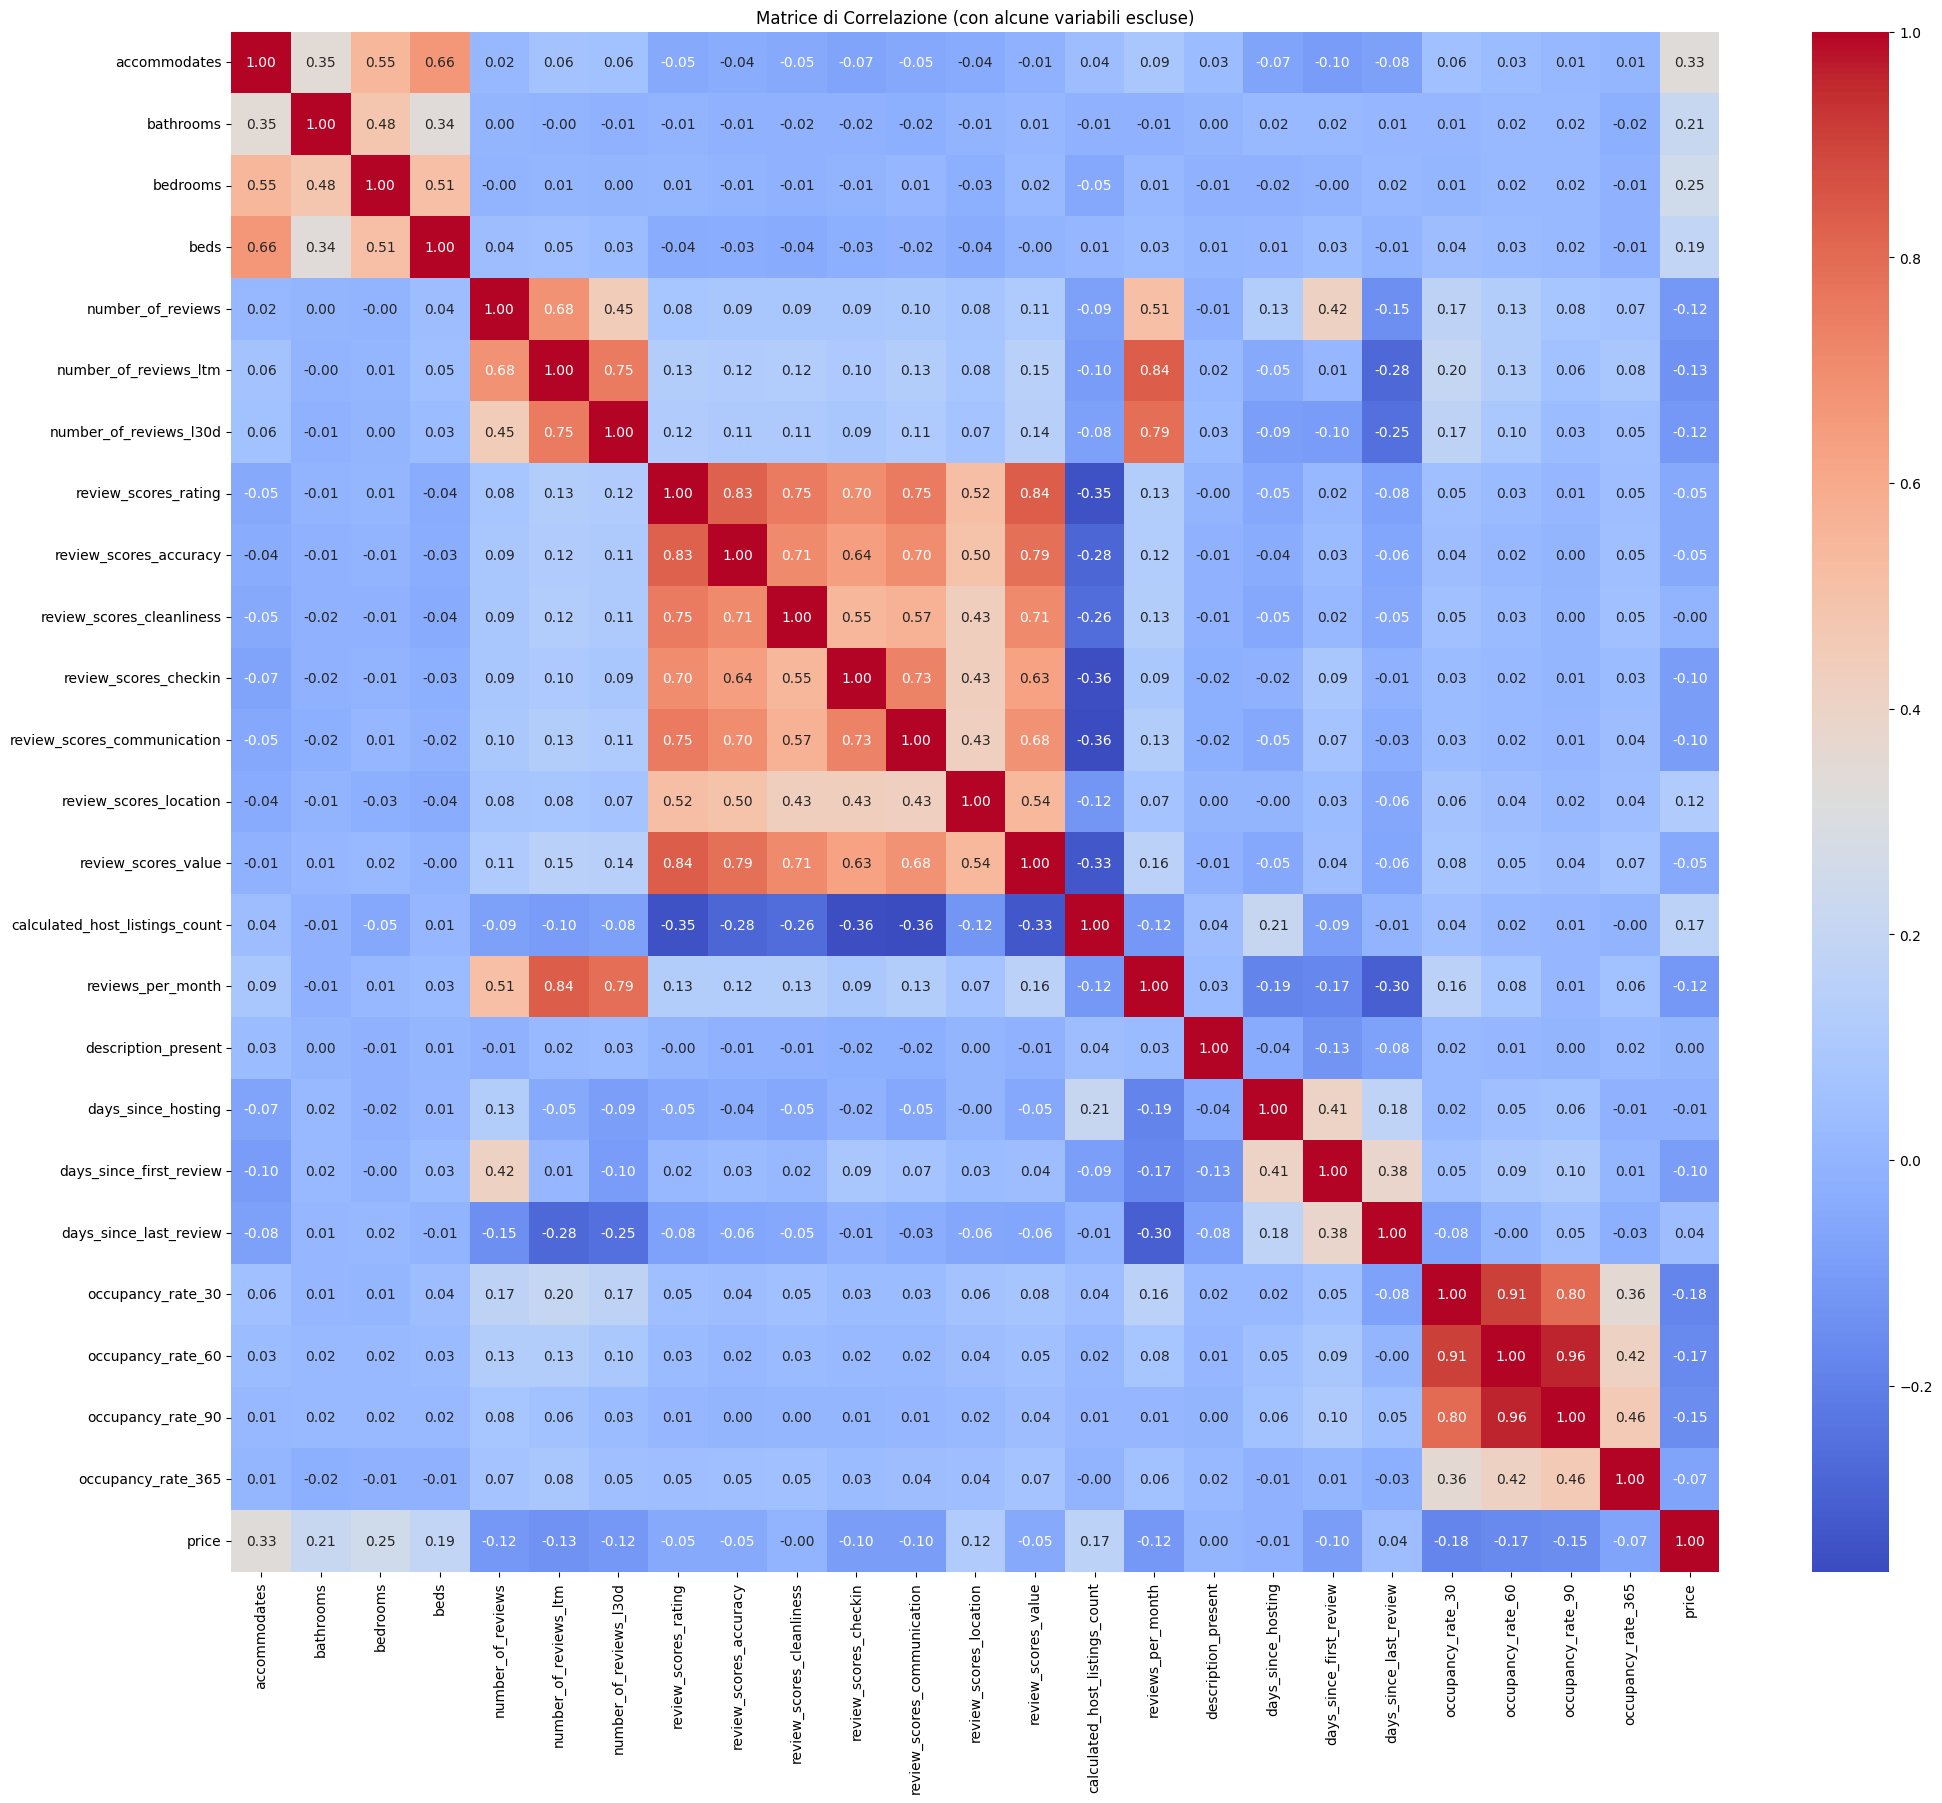

In [24]:
# Lista delle colonne da escludere
excluded_cols = ["id", "host_id", "availability_30", "availability_60", "availability_90", "availability_365"] 

# Crea una copia del DataFrame numerico
df_corr = X_train[num_cols].copy()

# Aggiungi la colonna 'price' (o qualunque target tu voglia includere)
df_corr["price"] = y_train

# Elimina le colonne indesiderate
df_corr.drop(columns=excluded_cols, inplace=True)

# Calcola la matrice di correlazione
corr_matrix = df_corr.corr()

# Visualizza l'heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di Correlazione (con alcune variabili escluse)")
plt.show()

# Correlation Matrix Analysis

1. **High correlations among accommodation size variables**  
   - Variables like `accommodates`, `bedrooms`, and `beds` show strong correlations (some > 0.9). This is expected, as larger listings with more bedrooms tend to have more beds and accommodate more guests.

2. **Strong interdependence among review scores**  
   - Columns such as `review_scores_rating`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, and `review_scores_value` are highly correlated (often > 0.6). This suggests that listings receiving high ratings in one category tend to score well across all aspects.

3. **Correlations among host activity variables**  
   - `days_since_hosting`, `days_since_first_review`, and `days_since_last_review` are strongly correlated (around 0.8–0.9). As time passes from the first or last review, the total number of days the host has been active also increases.

4. **Relationship between price and other metrics**  
   - `price` is moderately correlated with `accommodates`, `bedrooms`, and `bathrooms` (correlation coefficient between 0.2 and 0.3), indicating that larger listings or those with more bathrooms tend to be more expensive.  
   - A slight negative correlation exists between `price` and occupancy rates (`occupancy_rate_30`, `occupancy_rate_60`), suggesting that higher-priced listings may experience slightly lower booking rates.
   this could also suggest that hosts need to find the perfect spot between price and being booked.  (for the future: what will the optimal point be?)

5. **Number of reviews and review scores**  
   - Variables like `number_of_reviews`, `number_of_reviews_ltm`, and `reviews_per_month` are positively correlated.  
   - There is also a slight negative correlation with some review scores: as the number of reviews increases, the average ratings may decrease slightly, possibly due to a “regression to the mean” effect.

6. **Negative correlation between the number of listings per host and review scores**  
   - `calculated_host_listings_count` shows a weak/medium negative correlation (around -0.3) with review scores. Hosts managing multiple listings may provide a more "business-oriented" rather than personalized experience, which could result in slightly lower ratings on average.

7. **Other considerations**  
   - Some binary variables, such as `description_present`, show no significant correlations with other features, suggesting a negligible impact on most key metrics.  
   - Overall, the results confirm expected correlations (e.g., between accommodation size variables and review scores) while highlighting interesting insights, such as the need to control multicollinearity and the importance of key variables (`accommodates`, `beds`, `bedrooms`) in subsequent modeling stages.
